In [ ]:
#####################################################################
#   PROJET 5 - Catégorisez automatiquement des questions            #
#-------------------------------------------------------------------#
#   NOTEBOOK DE TEST :                                              #
#      ---> test des différents modèles.                            #
#####################################################################

In [ ]:
#!pip install pyldavis

In [58]:
# built-in (librairie par défaut avec python)
import os

# Data
import pandas as pd
import numpy as np

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint
import tqdm
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer

# Visualisation
import matplotlib.pyplot as plt
from PIL import Image

In [59]:
# Constantes
C_DATASET_SOURCE  = './data/source/'
C_DATASET_CLEANED = './data/cleaned/'

# 1. DONNEES

In [60]:
################################################
#      Chargement jeu de données               #
################################################
# Données nettoyées
df_all = pd.read_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', sep = '\t')

# Données nettoyées réduites
df = pd.read_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean_light.csv', sep = '\t')

In [61]:
print('df_all\tshape =', df_all.shape)
print('df\tshape =', df.shape)

df_all	shape = (207636, 17)
df	shape = (207636, 11)


In [62]:
df_all.columns

Index(['CreationDate', 'Id', 'Score', 'AnswerCount', '_Text', '_Tag_1',
       '_Tag_2', '_Text_sans_html', '_Text_tokens', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_len_Text', '_Tokens_text_clean',
       '_Tokens_stemmer_clean', '_Tokens_lemma_clean', '_len_Text_clean'],
      dtype='object')

In [63]:
df.columns

Index(['Id', 'Score', 'AnswerCount', '_Tag_1', '_Tag_2', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_Tokens_text_clean',
       '_Tokens_stemmer_clean', '_Tokens_lemma_clean'],
      dtype='object')

# 1.1. CORPUS TEXTE

In [ ]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.

In [64]:
# Colonne _Text_clean
corpus_text = ' '.join(df['_Text_clean'])

print('taille corpus_text =', f"{len(corpus_text):,}", '\n') # avec séparateur de milliers
print(corpus_text[:1_000])

taille corpus_text = 48,093,787 

registry programmer friendly registry setter appropriate torn situation throw appropriate understood whatever prefer sparse manipulation enormous matrices specifically pyramidal summation copula calculation short track relatively usually rare sea matrix multidimensional sparse assume undefined preset physically possibly zero million speed huge priority dynamically choose binary safe lazy construction singleton singleton lazily safe manner simultaneously singleton rely beforehand singleton safe construction integral constant executed ie executed perhaps singleton turn guard creation singleton excellent couple shame mark broad opposed pod atomic believe knew boost certainly grateful posted benefit regular fashion visual studio marked runner bug trick management studio management studio finally transact plan choosing radio buttons plan plan constantly constantly affect constantly regard supposed worry intended constant constantly experience greatly apprec

In [65]:
# Colonne _Stemmer_clean
corpus_stemmer = ' '.join(df['_Stemmer_clean'])

print('taille corpus_stemmer =', f"{len(corpus_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_stemmer[:1_000])

taille corpus_stemmer = 42,142,509 

registri programm friendli registri setter appropri torn situat throw appropri understood whatev prefer spars manipul enorm matric specif pyramid summat copula calcul short track rel usual rare sea matrix multidimension spars assum undefin preset physic possibl zero million speed huge prioriti dynam choos binari safe lazi construct singleton singleton lazili safe manner simultan singleton reli beforehand singleton safe construct integr constant execut ie execut perhap singleton turn guard creation singleton excel coupl shame mark broad oppos pod atom believ knew boost certainli grate post benefit regular fashion visual studio mark runner bug trick manag studio manag studio final transact plan choos radio button plan plan constantli constantli affect constantli regard suppos worri intend constant constantli experi greatli appreci clarifi especi import partial trust accept inde subsequ extrem fast disk explicitli fli final disk verifi beyond ever need

In [66]:
# Colonne _Lemma_clean
corpus_lemma = ' '.join(df['_Lemma_clean'])

print('taille corpus_lemma =', f"{len(corpus_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_lemma[:1_000])

taille corpus_lemma = 48,004,864 

registry programmer friendly registry setter appropriate torn situation throw appropriate understood whatever prefer sparse manipulation enormous matrix specifically pyramidal summation copula calculation short track relatively usually rare sea matrix multidimensional sparse assume undefined preset physically possibly zero million speed huge priority dynamically choose binary safe lazy construction singleton singleton lazily safe manner simultaneously singleton rely beforehand singleton safe construction integral constant executed ie executed perhaps singleton turn guard creation singleton excellent couple shame mark broad opposed pod atomic believe knew boost certainly grateful posted benefit regular fashion visual studio marked runner bug trick management studio management studio finally transact plan choosing radio button plan plan constantly constantly affect constantly regard supposed worry intended constant constantly experience greatly apprecia

# 1.2. CORPUS LISTE

In [67]:
corpus_liste_stemmer = []
corpus_liste_lemma   = []

corpus_liste_stemmer = corpus_stemmer.split()
corpus_liste_lemma   = corpus_lemma.split()

In [9]:
print('taille corpus_liste_stemmer =', f"{len(corpus_liste_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_liste_stemmer[:10]) # 10 premiers éléments de la liste

taille corpus_liste_stemmer = 6,472,773 

['registri', 'programm', 'friendli', 'registri', 'setter', 'appropri', 'torn', 'situat', 'throw', 'appropri']


In [10]:
print('taille corpus_liste_lemma =', f"{len(corpus_liste_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_liste_lemma[:10])  # 10 premiers éléments de la liste

taille corpus_liste_lemma = 6,470,732 

['registry', 'programmer', 'friendly', 'registry', 'setter', 'appropriate', 'torn', 'situation', 'throw', 'appropriate']


# 1.3. CORPUS LISTE DOC

In [ ]:
# https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
##############################################
#   Corpus sous forme de liste de documents  #
##############################################

In [11]:
corpus_liste_doc_stemmer = []
corpus_liste_doc_lemma   = []

# Updating corpus list : one string for one document :
# corpus = ['This is the first document.',
#           'This document is the second document.',
#           'And this is the third one.',
#           'Is this the first document?']

for index, row in df.iterrows():
    corpus_liste_doc_stemmer.append(row['_Stemmer_clean'])
    corpus_liste_doc_lemma.append(row['_Lemma_clean'])

In [12]:
print('taille corpus_liste_doc_stemmer =', f"{len(corpus_liste_doc_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_liste_doc_stemmer[:10]) # 10 premiers éléments de la liste

taille corpus_liste_doc_stemmer = 207,636 

['registri programm friendli registri', 'setter appropri torn situat throw appropri understood whatev prefer', 'spars manipul enorm matric specif pyramid summat copula calcul short track rel usual rare sea matrix multidimension spars assum undefin preset physic possibl zero million speed huge prioriti dynam choos binari', 'safe lazi construct singleton singleton lazili safe manner simultan singleton reli beforehand singleton safe construct integr constant execut ie execut perhap singleton turn guard creation singleton excel coupl shame mark broad oppos pod atom believ knew boost certainli grate post', 'benefit regular fashion visual studio', 'mark runner bug', 'trick manag studio manag studio final transact', 'plan choos radio button plan plan constantli constantli affect constantli regard suppos worri intend constant constantli experi greatli appreci clarifi especi import partial trust accept inde subsequ extrem fast disk explicitli fli fina

In [13]:
print('taille corpus_liste_doc_lemma =', f"{len(corpus_liste_doc_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_liste_doc_lemma[:10])  # 10 premiers éléments de la liste

taille corpus_liste_doc_lemma = 207,636 

['registry programmer friendly registry', 'setter appropriate torn situation throw appropriate understood whatever prefer', 'sparse manipulation enormous matrix specifically pyramidal summation copula calculation short track relatively usually rare sea matrix multidimensional sparse assume undefined preset physically possibly zero million speed huge priority dynamically choose binary', 'safe lazy construction singleton singleton lazily safe manner simultaneously singleton rely beforehand singleton safe construction integral constant executed ie executed perhaps singleton turn guard creation singleton excellent couple shame mark broad opposed pod atomic believe knew boost certainly grateful posted', 'benefit regular fashion visual studio', 'marked runner bug', 'trick management studio management studio finally transact', 'plan choosing radio button plan plan constantly constantly affect constantly regard supposed worry intended constant constant

# 1.4. TAGS : CORPUS & TOKENS

In [98]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.
corpus_tags_1 = ' '.join(df['_Tag_1'])
corpus_tags_1[:500]

'windows java c++ c++ .net .net sql c# http c# c# c# c# java c# c++ asp.net c++ http html c++ .net security image c# c# c# php performance c# c# php python database asp.net c++ python c# c# c# c# c# html java python c++ ruby-on-rails .net css sql-server java javascript java php sql c# asynchronous python sql c# c++ c# linux database linux java python java shell html java python java c# python windows image ios python c++ python c++ python java android ruby-on-rails c# c# bash c# c# windows python'

In [99]:
corpus_tags_2 = ' '.join(df['_Tag_2'])
corpus_tags_2[:500]

'/ exception / multithreading visual-studio visual-studio sql-server .net / asp.net performance c++ .net json .net / performance macos / / linux performance ssl / .net .net / http mysql .net xml mysql windows postgresql / / / optimization / asp.net .net asp.net css jquery linux unit-testing ruby performance / / security / c++ / database .net / / sql-server .net performance .net / / bash / sql c++ / string / / / .net authentication / / iphone / linux linux windows sql c++ iphone ruby javascript / '

In [100]:
corpus_tags = corpus_tags_1 + ' ' + corpus_tags_2
corpus_tags[len(corpus_tags_1) - 100: len(corpus_tags_1) + 200] # affichage corpus à cheval entre corpus_1 et corpus_2

'n ruby-on-rails c++ node.js java ios android angular c++ python javascript python c++ c++ javascript / exception / multithreading visual-studio visual-studio sql-server .net / asp.net performance c++ .net json .net / performance macos / / linux performance ssl / .net .net / http mysql .net xml mysql'

In [101]:
###########################
# Corpus au format token  #
###########################
token_tags = corpus_tags.split()
len(token_tags)

415272

In [102]:
print(token_tags[0:10])

['windows', 'java', 'c++', 'c++', '.net', '.net', 'sql', 'c#', 'http', 'c#']


In [104]:
count_tags = pd.Series(token_tags).value_counts()
count_tags

/                    68298
java                 26197
c#                   25081
javascript           23457
python               22977
                     ...  
cocoa-touch            463
jpa                    359
dataframe              322
twitter-bootstrap      299
spring-mvc             223
Name: count, Length: 100, dtype: int64

In [108]:
# Nombre de valeurs uniques
print('count_tags :', count_tags.nunique(), 'valeurs uniques')

count_tags : 96 valeurs uniques


In [112]:
liste_tags = count_tags.index.tolist()
print(liste_tags)

['/', 'java', 'c#', 'javascript', 'python', 'c++', 'android', 'ios', '.net', 'html', 'php', 'objective-c', 'c', 'node.js', 'jquery', 'spring', 'linux', 'sql', 'swift', 'iphone', 'ruby-on-rails', 'asp.net', 'css', 'performance', 'c++11', 'windows', 'reactjs', 'python-3.x', 'mysql', 'json', 'django', 'unit-testing', 'ruby', 'r', 'arrays', 'sql-server', 'macos', 'xcode', 'wpf', 'multithreading', 'asp.net-mvc', 'typescript', 'algorithm', 'amazon-web-services', 'git', 'angular', 'pandas', 'visual-studio', 'string', 'database', 'bash', 'docker', 'eclipse', 'scala', 'machine-learning', 'gcc', 'angularjs', 'postgresql', 'image', 'xml', 'laravel', 'rest', 'spring-boot', 'numpy', 'google-chrome', 'asp.net-core', 'maven', 'security', 'hibernate', 'http', 'qt', 'android-studio', 'ssl', 'authentication', 'firebase', 'assembly', 'templates', 'testing', 'debugging', 'shell', 'entity-framework', 'python-2.7', 'list', 'selenium', 'ubuntu', 'ajax', 'asynchronous', 'mongodb', 'regex', 'optimization', 'ap

# 2. MACHINE LEARNING NON SUPERVISE

# 2.1. TF-IDF

In [68]:
# https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

#############################################
#               TF-IDF matrix               #
#############################################
def tf_idf_matrix(corpus_liste_doc_in):
    # TF-IDF matrix
    tfidfvectorizer = TfidfVectorizer()
    train_data = tfidfvectorizer.fit_transform(corpus_liste_doc_in)

    sparsity = 1 - train_data.size / (train_data.shape[0] * train_data.shape[1])
    print("Sparsity =", sparsity)
    
    return tfidfvectorizer, train_data

In [15]:
# TF-IDF matrix du corpus corpus_stemmer
tfidfvectorizer_stemmer, train_data_stemmer = tf_idf_matrix(corpus_liste_doc_in = corpus_liste_doc_stemmer)

Sparsity = 0.9989575248242523


In [16]:
# TF-IDF matrix du corpus corpus_lemma
tfidfvectorizer_lemma, train_data_lemma = tf_idf_matrix(corpus_liste_doc_in = corpus_liste_doc_lemma)

Sparsity = 0.9991728921862256


# 2.2. TOPIC MODEL AVEC LDA (LATENT DIRICHLET ALLOCATION)

# 2.2.1. METHODE 1

In [ ]:
# Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data,
# which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.

In [91]:
################################################################
#    Topic modeling using LDA (Latent Dirichlet Allocation)    #
################################################################
# https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
# https://www.pluralsight.com/guides/topic-identification-nlp
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

# num_components_in = number of topics or components
def topic_modeling_with_LDA(normalization_type_in,
                            num_components_in, 
                            num_word_per_topic_in, 
                            tfidfvectorizer_in, 
                            train_data_in):
    
    # Generate TF-IDF Features
    ###################################
    #          Perform LDA            #
    ###################################
    # Create LDA object
    model = LatentDirichletAllocation(n_components = num_components_in)
    
    # Fit and Transform SVD model on data
    lda_matrix = model.fit_transform(train_data_in)

    # Get Components 
    lda_components = model.components_
    
    
    ###################################
    #   Extract topics and terms      #
    ###################################
    # Print the topics with their terms
    terms = tfidfvectorizer_in.get_feature_names()
    
    
    # affichage
    for index, component in enumerate(lda_components):
        zipped = zip(terms, component)
        top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:num_word_per_topic_in]
        top_terms_list = list(dict(top_terms_key).keys())
        print("Topic " + str(index) + " : " , top_terms_list)
        
    return lda_components, terms

In [121]:
dict_tags = {}
for tag in liste_tags:
    dict_tags[tag] = 0
    print(tag, dict_tags[tag] )
    

/ 0
java 0
c# 0
javascript 0
python 0
c++ 0
android 0
ios 0
.net 0
html 0
php 0
objective-c 0
c 0
node.js 0
jquery 0
spring 0
linux 0
sql 0
swift 0
iphone 0
ruby-on-rails 0
asp.net 0
css 0
performance 0
c++11 0
windows 0
reactjs 0
python-3.x 0
mysql 0
json 0
django 0
unit-testing 0
ruby 0
r 0
arrays 0
sql-server 0
macos 0
xcode 0
wpf 0
multithreading 0
asp.net-mvc 0
typescript 0
algorithm 0
amazon-web-services 0
git 0
angular 0
pandas 0
visual-studio 0
string 0
database 0
bash 0
docker 0
eclipse 0
scala 0
machine-learning 0
gcc 0
angularjs 0
postgresql 0
image 0
xml 0
laravel 0
rest 0
spring-boot 0
numpy 0
google-chrome 0
asp.net-core 0
maven 0
security 0
hibernate 0
http 0
qt 0
android-studio 0
ssl 0
authentication 0
firebase 0
assembly 0
templates 0
testing 0
debugging 0
shell 0
entity-framework 0
python-2.7 0
list 0
selenium 0
ubuntu 0
ajax 0
asynchronous 0
mongodb 0
regex 0
optimization 0
api 0
gradle 0
winforms 0
exception 0
cocoa 0
cocoa-touch 0
jpa 0
dataframe 0
twitter-bootstra

In [167]:
def graphique_topic_modeling_with_LDA(normalization_type_in, num_word_per_topic_in, lda_components_in, terms_in):
    
    # Dictionnaire avec le nombre de tags rencontrés
    dict_tags = {}
    
    
    for index_topic, component in enumerate(lda_components_in):
            zipped = zip(terms_in, component)
            top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:num_word_per_topic_in]
            top_terms_list = list(dict(top_terms_key).keys())
            print('\n\n', '@' * 100)
            print('Topic ' + str(index_topic) + ' : ' , top_terms_list, '\n')
        
        
            # Initialisation d'un dictionnaire avec le nombre de tags rencontrés (avant d'étudier chaque
            # nouvelle liste de mots)
            for tag in liste_tags:
                dict_tags[tag] = 0
        
        
            for word in top_terms_list:
                if (normalization_type_in == 'lemma'):
                    colonne = '_Tokens_lemma_clean'
                else:
                    colonne = '_Tokens_stemmer_clean'

                # sous-dataframe contenant le mot
                df_word = df[df[colonne].str.contains(word)]
                print('word =', word, ', df_word.shape =', df_word.shape)
                
                # Parcours des lignes contenant le mot pour comptage
                for index_word, row in df_word.iterrows():
                    tag_1 = row['_Tag_1']
                    tag_2 = row['_Tag_2']
            
                    dict_tags[tag_1] = dict_tags[tag_1] + 1
                    dict_tags[tag_2] = dict_tags[tag_2] + 1            
                print('word =', word, ', _Tag_1 =', dict_tags[tag_1], ', _Tag_2 =', dict_tags[tag_2])
            
            print('\ndict_tags =', dict_tags, '\n')
            
            
            # Affichage graphique
            plt.figure(figsize = (12, 4))

            # Suppression des éléments les plus rares
            # https://www.mypycode.com/fr/Python/1001006101.html
            for key, value in dict(dict_tags).items():
                if ((key == '/') | (value <= 2000)):
                    del dict_tags[key]

            myList = dict_tags.items()
            print(myList)
            myList = sorted(myList) 
            x, y = zip(*myList) 

            plt.plot(x, y)
            plt.xticks(rotation = 90)
            plt.xlabel('Key')
            plt.ylabel('Value')
            plt.title('Tags topic ' + str(index_topic) + ' : ' + str(top_terms_list))
            plt.show() 

In [ ]:
####################################
# LDA corpus stemmer               #
####################################

In [92]:
lda_components_stemmer, terms_stemmer = topic_modeling_with_LDA(normalization_type_in = 'stemmer',
                                                                num_components_in     = 8, 
                                                                num_word_per_topic_in = 12, 
                                                                tfidfvectorizer_in    = tfidfvectorizer_stemmer, 
                                                                train_data_in         = train_data_stemmer)  # 4 min

Topic 0 :  ['doubl', 'vector', 'float', 'column', 'integ', 'audio', 'rang', 'matrix', 'sum', 'scala', 'express', 'oper']
Topic 1 :  ['div', 'react', 'compon', 'label', 'titl', 'cell', 'swift', 'grid', 'li', 'bind', 'render', 'span']
Topic 2 :  ['android', 'activ', 'anim', 'click', 'font', 'chrome', 'scroll', 'intent', 'overrid', 'canva', 'mobil', 'document']
Topic 3 :  ['token', 'password', 'authent', 'login', 'secur', 'certif', 'train', 'author', 'account', 'plot', 'proxi', 'domain']
Topic 4 :  ['entiti', 'asp', 'git', 'control', 'column', 'session', 'valid', 'person', 'tabl', 'rout', 'repositori', 'schema']
Topic 5 :  ['studio', 'visual', 'docker', 'angular', 'rubi', 'chrome', 'selenium', 'bash', 'browser', 'mac', 'shell', 'echo']
Topic 6 :  ['char', 'assembl', 'boost', 'oper', 'gener', 'lock', 'pointer', 'queue', 'clang', 'await', 'link', 'free']
Topic 7 :  ['spring', 'eclips', 'jar', 'apach', 'hibern', 'boot', 'depend', 'bean', 'annot', 'mock', 'tomcat', 'sun']


C:\Users\valdu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)




 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 0 :  ['doubl', 'vector', 'float', 'column', 'integ', 'audio', 'rang', 'matrix', 'sum', 'scala', 'express', 'oper'] 

word = doubl , df_word.shape = (4588, 11)
word = doubl , _Tag_1 = 728 , _Tag_2 = 241
word = vector , df_word.shape = (3219, 11)
word = vector , _Tag_1 = 251 , _Tag_2 = 451
word = float , df_word.shape = (4009, 11)
word = float , _Tag_1 = 1570 , _Tag_2 = 4427
word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 3390 , _Tag_2 = 100
word = integ , df_word.shape = (8102, 11)
word = integ , _Tag_1 = 4339 , _Tag_2 = 243
word = audio , df_word.shape = (1721, 11)
word = audio , _Tag_1 = 1716 , _Tag_2 = 101
word = rang , df_word.shape = (8432, 11)
word = rang , _Tag_1 = 6808 , _Tag_2 = 1419
word = matrix , df_word.shape = (2097, 11)
word = matrix , _Tag_1 = 810 , _Tag_2 = 1177
word = sum , df_word.shape = (14088, 11)
word = sum , _Tag_1 = 2724 , _Tag_2 = 77

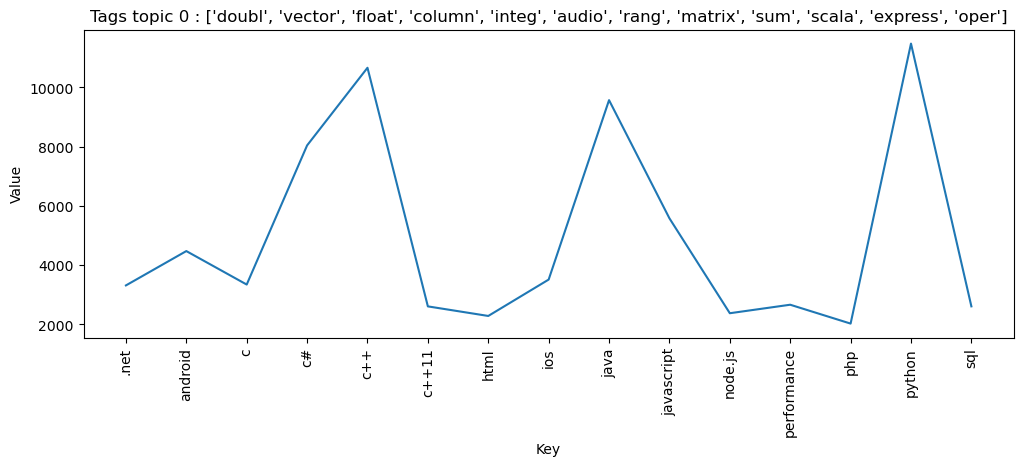



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 1 :  ['div', 'react', 'compon', 'label', 'titl', 'cell', 'swift', 'grid', 'li', 'bind', 'render', 'span'] 

word = div , df_word.shape = (10987, 11)
word = div , _Tag_1 = 4283 , _Tag_2 = 220
word = react , df_word.shape = (4978, 11)
word = react , _Tag_1 = 772 , _Tag_2 = 89
word = compon , df_word.shape = (6262, 11)
word = compon , _Tag_1 = 8582 , _Tag_2 = 5814
word = label , df_word.shape = (4800, 11)
word = label , _Tag_1 = 1237 , _Tag_2 = 296
word = titl , df_word.shape = (8496, 11)
word = titl , _Tag_1 = 673 , _Tag_2 = 10076
word = cell , df_word.shape = (2408, 11)
word = cell , _Tag_1 = 547 , _Tag_2 = 278
word = swift , df_word.shape = (3051, 11)
word = swift , _Tag_1 = 11503 , _Tag_2 = 358
word = grid , df_word.shape = (2307, 11)
word = grid , _Tag_1 = 860 , _Tag_2 = 12190
word = li , df_word.shape = (98868, 11)
word = li , _Tag_1 = 8933 , _Tag_2 = 45156
word = bind , df_

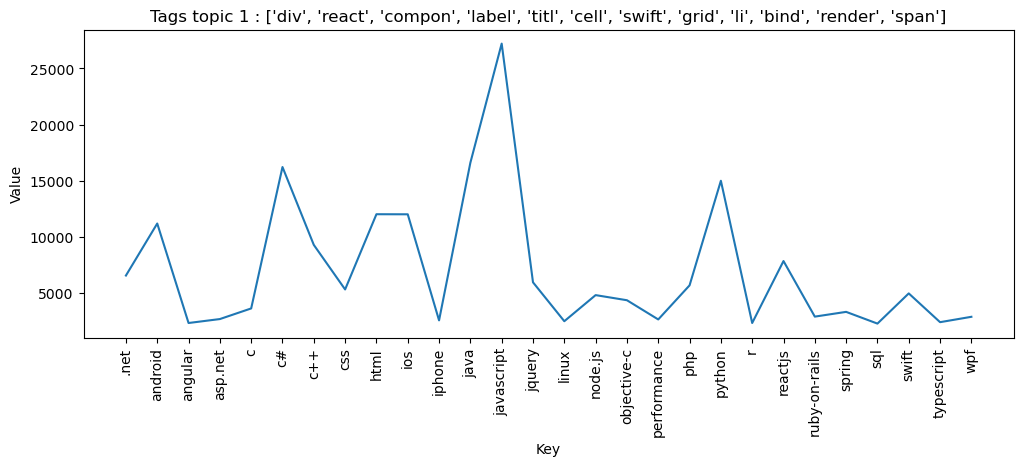



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 2 :  ['android', 'activ', 'anim', 'click', 'font', 'chrome', 'scroll', 'intent', 'overrid', 'canva', 'mobil', 'document'] 

word = android , df_word.shape = (14486, 11)
word = android , _Tag_1 = 12720 , _Tag_2 = 289
word = activ , df_word.shape = (9117, 11)
word = activ , _Tag_1 = 4737 , _Tag_2 = 148
word = anim , df_word.shape = (3543, 11)
word = anim , _Tag_1 = 2081 , _Tag_2 = 272
word = click , df_word.shape = (8817, 11)
word = click , _Tag_1 = 536 , _Tag_2 = 13019
word = font , df_word.shape = (2882, 11)
word = font , _Tag_1 = 497 , _Tag_2 = 13918
word = chrome , df_word.shape = (6233, 11)
word = chrome , _Tag_1 = 2143 , _Tag_2 = 428
word = scroll , df_word.shape = (2758, 11)
word = scroll , _Tag_1 = 5041 , _Tag_2 = 2298
word = intent , df_word.shape = (2437, 11)
word = intent , _Tag_1 = 1010 , _Tag_2 = 336
word = overrid , df_word.shape = (9165, 11)
word = overrid , _Tag_1

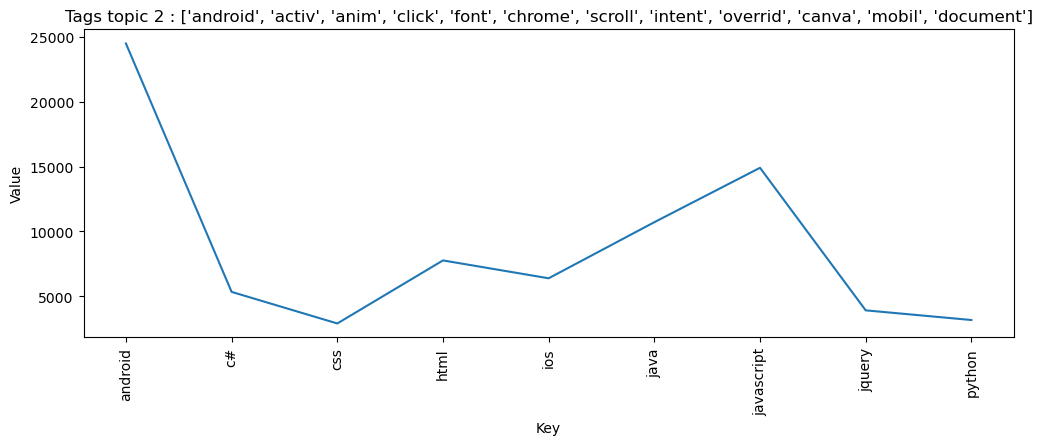



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 3 :  ['token', 'password', 'authent', 'login', 'secur', 'certif', 'train', 'author', 'account', 'plot', 'proxi', 'domain'] 

word = token , df_word.shape = (5035, 11)
word = token , _Tag_1 = 209 , _Tag_2 = 1638
word = password , df_word.shape = (7024, 11)
word = password , _Tag_1 = 1633 , _Tag_2 = 496
word = authent , df_word.shape = (5656, 11)
word = authent , _Tag_1 = 1045 , _Tag_2 = 317
word = login , df_word.shape = (5487, 11)
word = login , _Tag_1 = 684 , _Tag_2 = 266
word = secur , df_word.shape = (7033, 11)
word = secur , _Tag_1 = 1305 , _Tag_2 = 309
word = certif , df_word.shape = (2089, 11)
word = certif , _Tag_1 = 431 , _Tag_2 = 78
word = train , df_word.shape = (3794, 11)
word = train , _Tag_1 = 3793 , _Tag_2 = 166
word = author , df_word.shape = (4913, 11)
word = author , _Tag_1 = 884 , _Tag_2 = 385
word = account , df_word.shape = (3690, 11)
word = account , _Tag_1

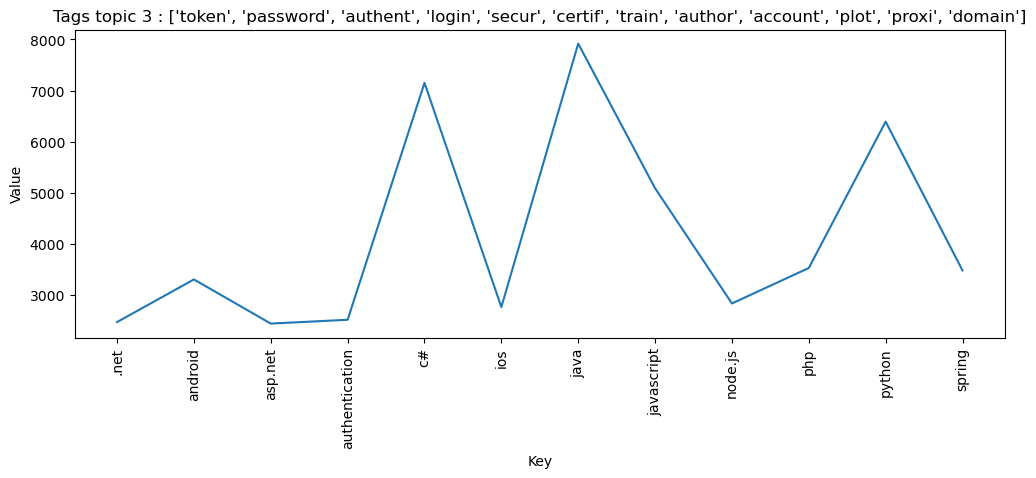



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 4 :  ['entiti', 'asp', 'git', 'control', 'column', 'session', 'valid', 'person', 'tabl', 'rout', 'repositori', 'schema'] 

word = entiti , df_word.shape = (5349, 11)
word = entiti , _Tag_1 = 526 , _Tag_2 = 199
word = asp , df_word.shape = (7744, 11)
word = asp , _Tag_1 = 5247 , _Tag_2 = 1721
word = git , df_word.shape = (4928, 11)
word = git , _Tag_1 = 278 , _Tag_2 = 160
word = control , df_word.shape = (7974, 11)
word = control , _Tag_1 = 951 , _Tag_2 = 6639
word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 2668 , _Tag_2 = 192
word = session , df_word.shape = (6052, 11)
word = session , _Tag_1 = 575 , _Tag_2 = 10643
word = valid , df_word.shape = (5262, 11)
word = valid , _Tag_1 = 4224 , _Tag_2 = 465
word = person , df_word.shape = (2907, 11)
word = person , _Tag_1 = 1682 , _Tag_2 = 793
word = tabl , df_word.shape = (8936, 11)
word = tabl , _Tag_1 = 1462 , _T

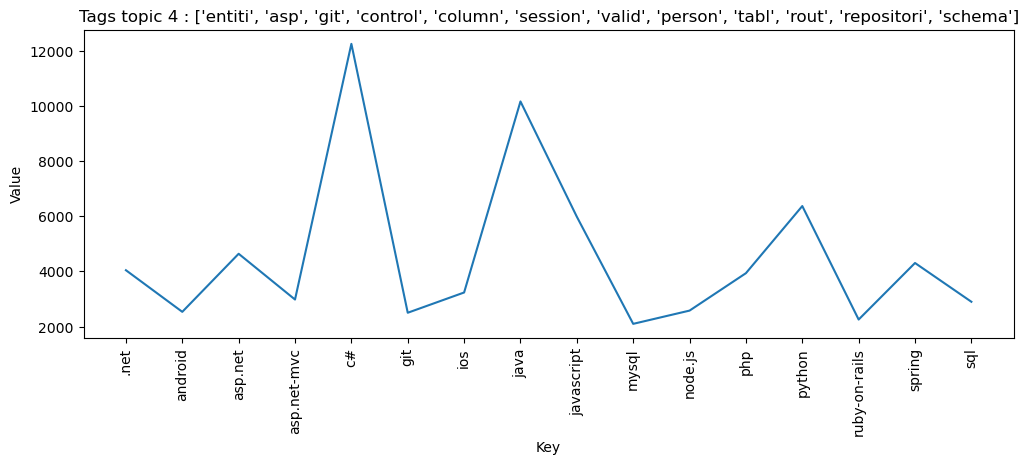



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 5 :  ['studio', 'visual', 'docker', 'angular', 'rubi', 'chrome', 'selenium', 'bash', 'browser', 'mac', 'shell', 'echo'] 

word = studio , df_word.shape = (7922, 11)
word = studio , _Tag_1 = 1851 , _Tag_2 = 126
word = visual , df_word.shape = (7201, 11)
word = visual , _Tag_1 = 234 , _Tag_2 = 36
word = docker , df_word.shape = (2165, 11)
word = docker , _Tag_1 = 309 , _Tag_2 = 46
word = angular , df_word.shape = (4145, 11)
word = angular , _Tag_1 = 1566 , _Tag_2 = 102
word = rubi , df_word.shape = (2827, 11)
word = rubi , _Tag_1 = 1535 , _Tag_2 = 1557
word = chrome , df_word.shape = (6233, 11)
word = chrome , _Tag_1 = 1420 , _Tag_2 = 291
word = selenium , df_word.shape = (1496, 11)
word = selenium , _Tag_1 = 1953 , _Tag_2 = 939
word = bash , df_word.shape = (2317, 11)
word = bash , _Tag_1 = 1011 , _Tag_2 = 266
word = browser , df_word.shape = (8799, 11)
word = browser , _Tag_1 =

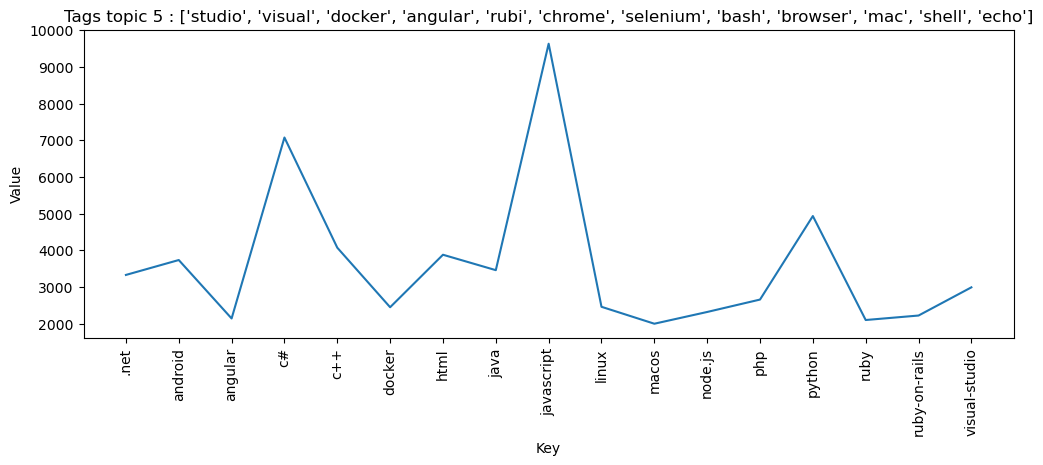



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 6 :  ['char', 'assembl', 'boost', 'oper', 'gener', 'lock', 'pointer', 'queue', 'clang', 'await', 'link', 'free'] 

word = char , df_word.shape = (6521, 11)
word = char , _Tag_1 = 239 , _Tag_2 = 9
word = assembl , df_word.shape = (3605, 11)
word = assembl , _Tag_1 = 2733 , _Tag_2 = 505
word = boost , df_word.shape = (1622, 11)
word = boost , _Tag_1 = 4103 , _Tag_2 = 465
word = oper , df_word.shape = (12292, 11)
word = oper , _Tag_1 = 2167 , _Tag_2 = 431
word = gener , df_word.shape = (12765, 11)
word = gener , _Tag_1 = 379 , _Tag_2 = 12686
word = lock , df_word.shape = (5934, 11)
word = lock , _Tag_1 = 4766 , _Tag_2 = 1154
word = pointer , df_word.shape = (3331, 11)
word = pointer , _Tag_1 = 10037 , _Tag_2 = 15647
word = queue , df_word.shape = (2454, 11)
word = queue , _Tag_1 = 2442 , _Tag_2 = 634
word = clang , df_word.shape = (2237, 11)
word = clang , _Tag_1 = 636 , _Tag_2 = 

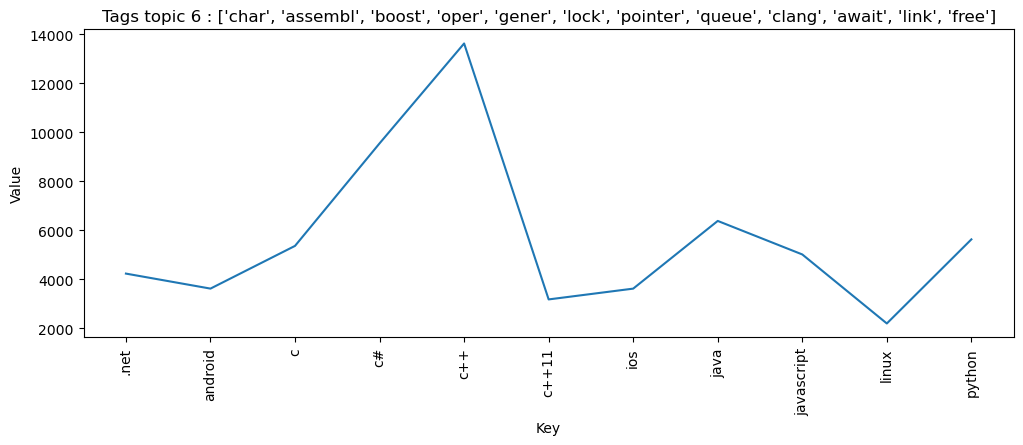



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 7 :  ['spring', 'eclips', 'jar', 'apach', 'hibern', 'boot', 'depend', 'bean', 'annot', 'mock', 'tomcat', 'sun'] 

word = spring , df_word.shape = (6634, 11)
word = spring , _Tag_1 = 4796 , _Tag_2 = 24
word = eclips , df_word.shape = (3357, 11)
word = eclips , _Tag_1 = 6775 , _Tag_2 = 309
word = jar , df_word.shape = (3631, 11)
word = jar , _Tag_1 = 1490 , _Tag_2 = 252
word = apach , df_word.shape = (4944, 11)
word = apach , _Tag_1 = 11582 , _Tag_2 = 1146
word = hibern , df_word.shape = (2580, 11)
word = hibern , _Tag_1 = 1435 , _Tag_2 = 269
word = boot , df_word.shape = (6094, 11)
word = boot , _Tag_1 = 2637 , _Tag_2 = 5575
word = depend , df_word.shape = (9300, 11)
word = depend , _Tag_1 = 331 , _Tag_2 = 112
word = bean , df_word.shape = (2467, 11)
word = bean , _Tag_1 = 19311 , _Tag_2 = 1746
word = annot , df_word.shape = (3161, 11)
word = annot , _Tag_1 = 3062 , _Tag_2 = 474

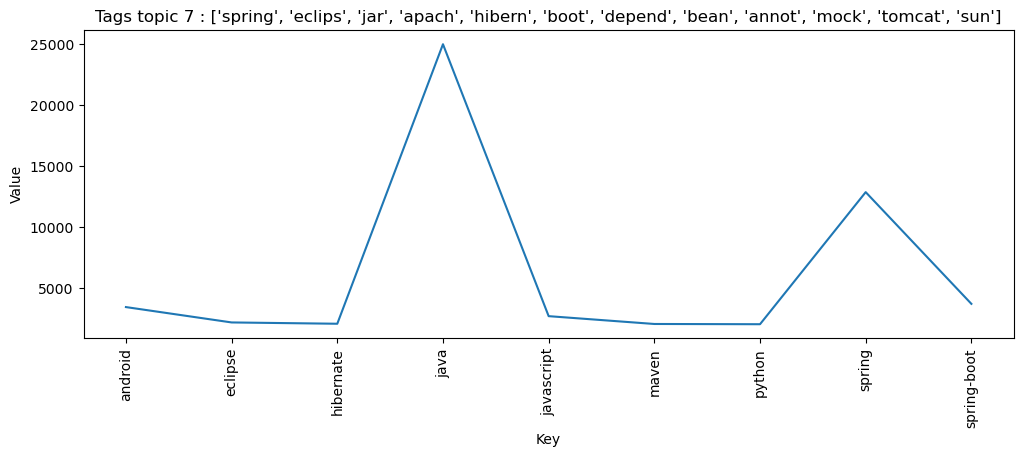

In [168]:
# graphique
graphique_topic_modeling_with_LDA(normalization_type_in = 'stemmer', 
                                  num_word_per_topic_in = 12, 
                                  lda_components_in     = lda_components_stemmer, 
                                  terms_in              = terms_stemmer)

In [ ]:
####################################
# LDA corpus lemma                 #
####################################

In [94]:
lda_components, terms = topic_modeling_with_LDA(normalization_type_in = 'lemma',
                                                num_components_in     = 8, 
                                                num_word_per_topic_in = 12, 
                                                tfidfvectorizer_in    = tfidfvectorizer_lemma, 
                                                train_data_in         = train_data_lemma) # 6 min

Topic 0 :  ['git', 'ruby', 'bash', 'mac', 'pip', 'shell', 'studio', 'android', 'echo', 'visual', 'terminal', 'notification']
Topic 1 :  ['swift', 'selenium', 'person', 'td', 'driver', 'objective', 'column', 'nil', 'mail', 'age', 'migration', 'entity']
Topic 2 :  ['react', 'entity', 'component', 'hibernate', 'angular', 'jar', 'spring', 'apache', 'eclipse', 'mock', 'dependency', 'column']
Topic 3 :  ['div', 'click', 'font', 'document', 'chrome', 'label', 'title', 'cell', 'scroll', 'browser', 'li', 'canvas']
Topic 4 :  ['matrix', 'audio', 'plot', 'shape', 'camera', 'range', 'train', 'float', 'column', 'axis', 'nan', 'ax']
Topic 5 :  ['char', 'vector', 'double', 'pointer', 'operator', 'boost', 'expression', 'integer', 'clang', 'unsigned', 'bool', 'member']
Topic 6 :  ['android', 'token', 'password', 'login', 'asp', 'authentication', 'studio', 'activity', 'session', 'security', 'intent', 'certificate']
Topic 7 :  ['spring', 'docker', 'await', 'controller', 'err', 'proxy', 'queue', 'boot', '



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 0 :  ['doubl', 'vector', 'float', 'column', 'integ', 'audio', 'rang', 'matrix', 'sum', 'scala', 'express', 'oper'] 

word = doubl , df_word.shape = (4588, 11)
word = doubl , _Tag_1 = 728 , _Tag_2 = 241
word = vector , df_word.shape = (3219, 11)
word = vector , _Tag_1 = 251 , _Tag_2 = 451
word = float , df_word.shape = (4009, 11)
word = float , _Tag_1 = 1570 , _Tag_2 = 4427
word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 3390 , _Tag_2 = 100
word = integ , df_word.shape = (8102, 11)
word = integ , _Tag_1 = 4339 , _Tag_2 = 243
word = audio , df_word.shape = (1721, 11)
word = audio , _Tag_1 = 1716 , _Tag_2 = 101
word = rang , df_word.shape = (8432, 11)
word = rang , _Tag_1 = 6808 , _Tag_2 = 1419
word = matrix , df_word.shape = (2097, 11)
word = matrix , _Tag_1 = 810 , _Tag_2 = 1177
word = sum , df_word.shape = (14088, 11)
word = sum , _Tag_1 = 2724 , _Tag_2 = 77

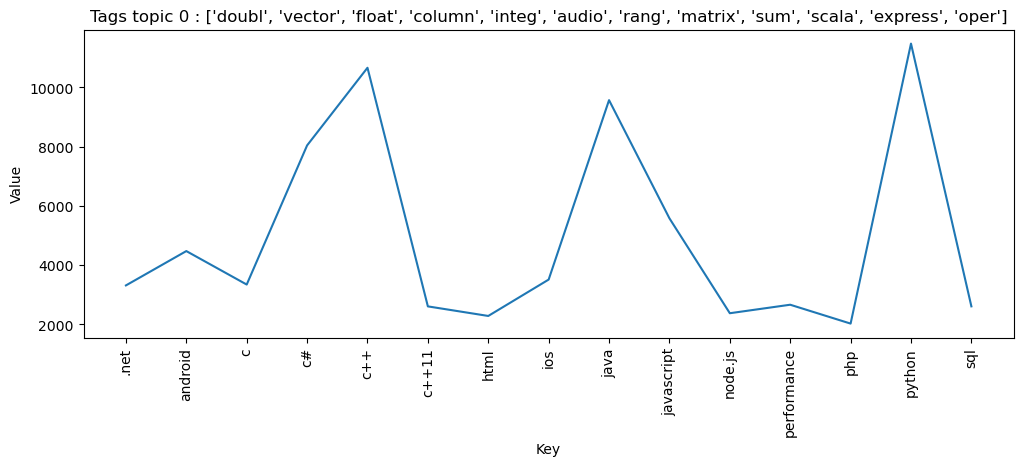



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 1 :  ['div', 'react', 'compon', 'label', 'titl', 'cell', 'swift', 'grid', 'li', 'bind', 'render', 'span'] 

word = div , df_word.shape = (10987, 11)
word = div , _Tag_1 = 4283 , _Tag_2 = 220
word = react , df_word.shape = (4978, 11)
word = react , _Tag_1 = 772 , _Tag_2 = 89
word = compon , df_word.shape = (6262, 11)
word = compon , _Tag_1 = 8582 , _Tag_2 = 5814
word = label , df_word.shape = (4800, 11)
word = label , _Tag_1 = 1237 , _Tag_2 = 296
word = titl , df_word.shape = (8496, 11)
word = titl , _Tag_1 = 673 , _Tag_2 = 10076
word = cell , df_word.shape = (2408, 11)
word = cell , _Tag_1 = 547 , _Tag_2 = 278
word = swift , df_word.shape = (3051, 11)
word = swift , _Tag_1 = 11503 , _Tag_2 = 358
word = grid , df_word.shape = (2307, 11)
word = grid , _Tag_1 = 860 , _Tag_2 = 12190
word = li , df_word.shape = (98868, 11)
word = li , _Tag_1 = 8933 , _Tag_2 = 45156
word = bind , df_

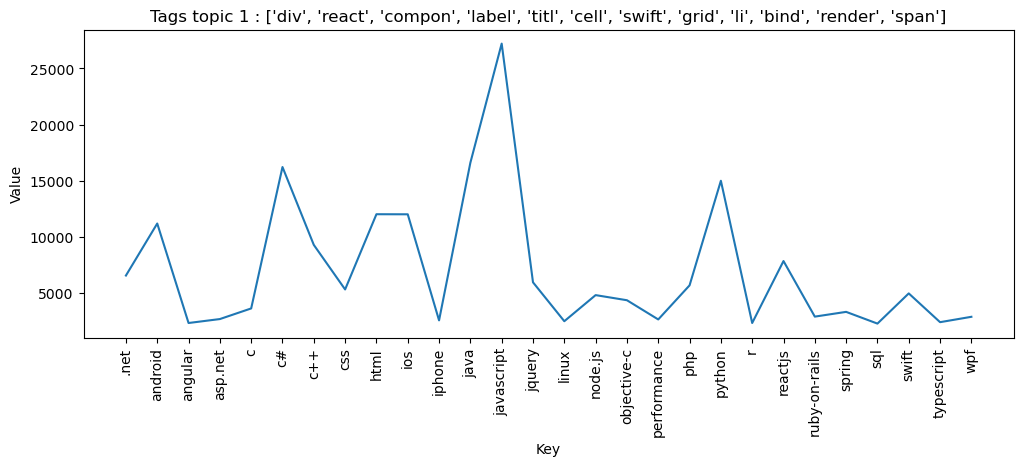



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 2 :  ['android', 'activ', 'anim', 'click', 'font', 'chrome', 'scroll', 'intent', 'overrid', 'canva', 'mobil', 'document'] 

word = android , df_word.shape = (14486, 11)
word = android , _Tag_1 = 12720 , _Tag_2 = 289
word = activ , df_word.shape = (9117, 11)
word = activ , _Tag_1 = 4737 , _Tag_2 = 148
word = anim , df_word.shape = (3543, 11)
word = anim , _Tag_1 = 2081 , _Tag_2 = 272
word = click , df_word.shape = (8817, 11)
word = click , _Tag_1 = 536 , _Tag_2 = 13019
word = font , df_word.shape = (2882, 11)
word = font , _Tag_1 = 497 , _Tag_2 = 13918
word = chrome , df_word.shape = (6233, 11)
word = chrome , _Tag_1 = 2143 , _Tag_2 = 428
word = scroll , df_word.shape = (2758, 11)
word = scroll , _Tag_1 = 5041 , _Tag_2 = 2298
word = intent , df_word.shape = (2437, 11)
word = intent , _Tag_1 = 1010 , _Tag_2 = 336
word = overrid , df_word.shape = (9165, 11)
word = overrid , _Tag_1

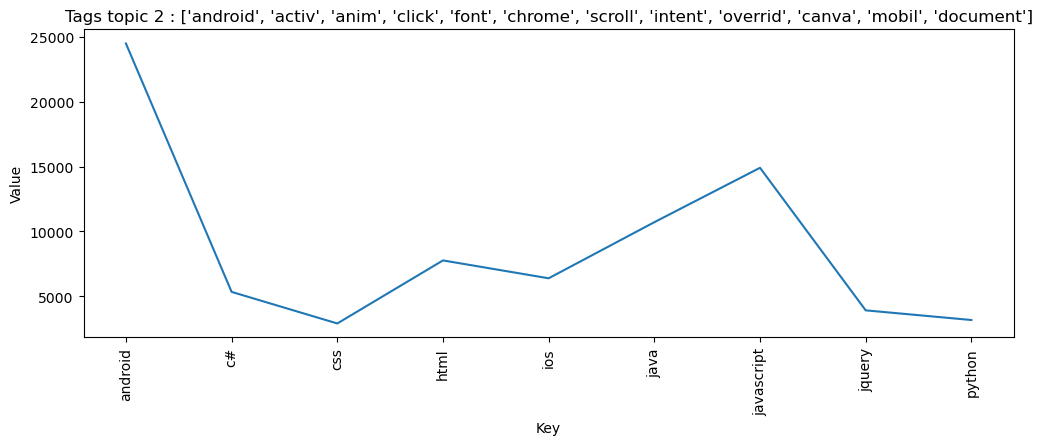



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 3 :  ['token', 'password', 'authent', 'login', 'secur', 'certif', 'train', 'author', 'account', 'plot', 'proxi', 'domain'] 

word = token , df_word.shape = (5035, 11)
word = token , _Tag_1 = 209 , _Tag_2 = 1638
word = password , df_word.shape = (7024, 11)
word = password , _Tag_1 = 1633 , _Tag_2 = 496
word = authent , df_word.shape = (5656, 11)
word = authent , _Tag_1 = 1045 , _Tag_2 = 317
word = login , df_word.shape = (5487, 11)
word = login , _Tag_1 = 684 , _Tag_2 = 266
word = secur , df_word.shape = (7033, 11)
word = secur , _Tag_1 = 1305 , _Tag_2 = 309
word = certif , df_word.shape = (2089, 11)
word = certif , _Tag_1 = 431 , _Tag_2 = 78
word = train , df_word.shape = (3794, 11)
word = train , _Tag_1 = 3793 , _Tag_2 = 166
word = author , df_word.shape = (4913, 11)
word = author , _Tag_1 = 884 , _Tag_2 = 385
word = account , df_word.shape = (3690, 11)
word = account , _Tag_1

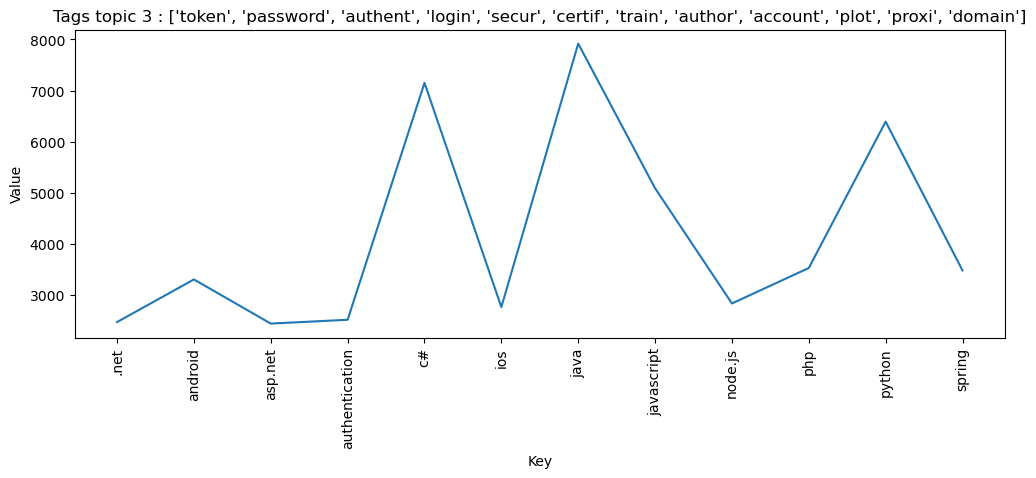



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 4 :  ['entiti', 'asp', 'git', 'control', 'column', 'session', 'valid', 'person', 'tabl', 'rout', 'repositori', 'schema'] 

word = entiti , df_word.shape = (5349, 11)
word = entiti , _Tag_1 = 526 , _Tag_2 = 199
word = asp , df_word.shape = (7744, 11)
word = asp , _Tag_1 = 5247 , _Tag_2 = 1721
word = git , df_word.shape = (4928, 11)
word = git , _Tag_1 = 278 , _Tag_2 = 160
word = control , df_word.shape = (7974, 11)
word = control , _Tag_1 = 951 , _Tag_2 = 6639
word = column , df_word.shape = (7995, 11)
word = column , _Tag_1 = 2668 , _Tag_2 = 192
word = session , df_word.shape = (6052, 11)
word = session , _Tag_1 = 575 , _Tag_2 = 10643
word = valid , df_word.shape = (5262, 11)
word = valid , _Tag_1 = 4224 , _Tag_2 = 465
word = person , df_word.shape = (2907, 11)
word = person , _Tag_1 = 1682 , _Tag_2 = 793
word = tabl , df_word.shape = (8936, 11)
word = tabl , _Tag_1 = 1462 , _T

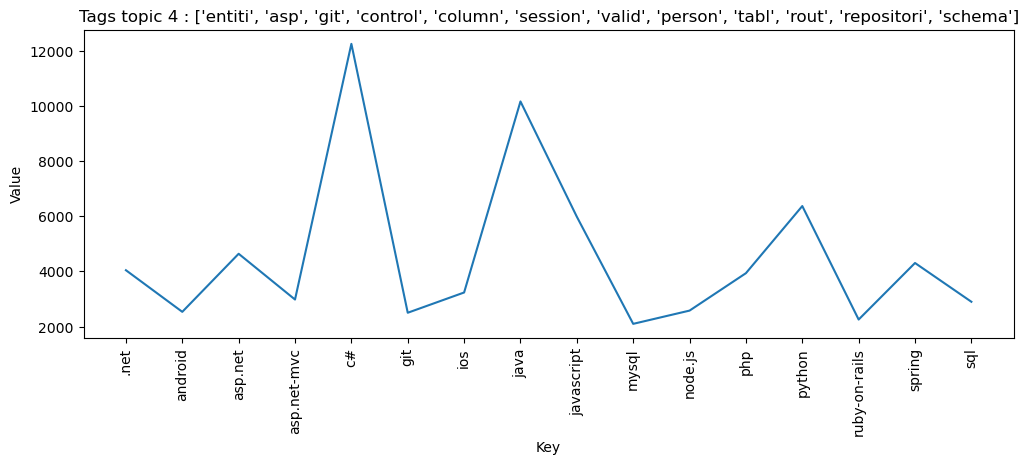



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 5 :  ['studio', 'visual', 'docker', 'angular', 'rubi', 'chrome', 'selenium', 'bash', 'browser', 'mac', 'shell', 'echo'] 

word = studio , df_word.shape = (7922, 11)
word = studio , _Tag_1 = 1851 , _Tag_2 = 126
word = visual , df_word.shape = (7201, 11)
word = visual , _Tag_1 = 234 , _Tag_2 = 36
word = docker , df_word.shape = (2165, 11)
word = docker , _Tag_1 = 309 , _Tag_2 = 46
word = angular , df_word.shape = (4145, 11)
word = angular , _Tag_1 = 1566 , _Tag_2 = 102
word = rubi , df_word.shape = (2827, 11)
word = rubi , _Tag_1 = 1535 , _Tag_2 = 1557
word = chrome , df_word.shape = (6233, 11)
word = chrome , _Tag_1 = 1420 , _Tag_2 = 291
word = selenium , df_word.shape = (1496, 11)
word = selenium , _Tag_1 = 1953 , _Tag_2 = 939
word = bash , df_word.shape = (2317, 11)
word = bash , _Tag_1 = 1011 , _Tag_2 = 266
word = browser , df_word.shape = (8799, 11)
word = browser , _Tag_1 =

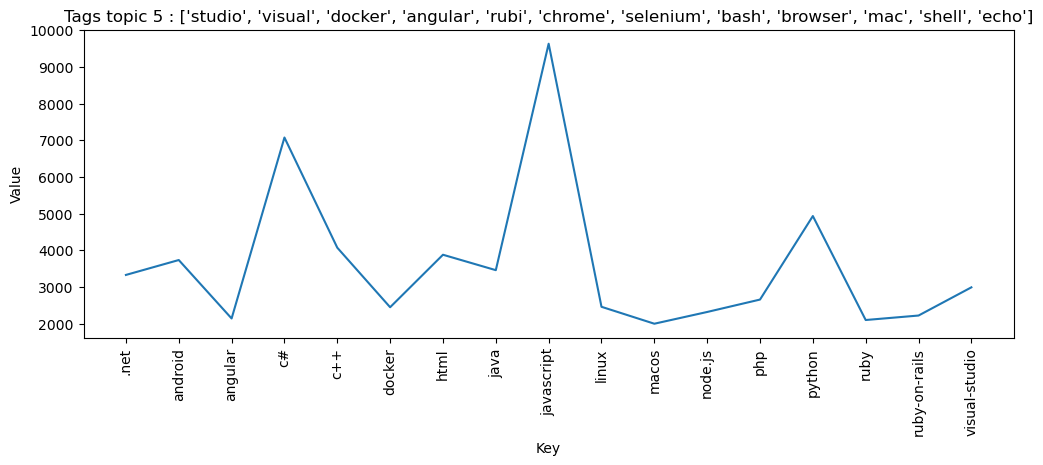



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 6 :  ['char', 'assembl', 'boost', 'oper', 'gener', 'lock', 'pointer', 'queue', 'clang', 'await', 'link', 'free'] 

word = char , df_word.shape = (6521, 11)
word = char , _Tag_1 = 239 , _Tag_2 = 9
word = assembl , df_word.shape = (3605, 11)
word = assembl , _Tag_1 = 2733 , _Tag_2 = 505
word = boost , df_word.shape = (1622, 11)
word = boost , _Tag_1 = 4103 , _Tag_2 = 465
word = oper , df_word.shape = (12292, 11)
word = oper , _Tag_1 = 2167 , _Tag_2 = 431
word = gener , df_word.shape = (12765, 11)
word = gener , _Tag_1 = 379 , _Tag_2 = 12686
word = lock , df_word.shape = (5934, 11)
word = lock , _Tag_1 = 4766 , _Tag_2 = 1154
word = pointer , df_word.shape = (3331, 11)
word = pointer , _Tag_1 = 10037 , _Tag_2 = 15647
word = queue , df_word.shape = (2454, 11)
word = queue , _Tag_1 = 2442 , _Tag_2 = 634
word = clang , df_word.shape = (2237, 11)
word = clang , _Tag_1 = 636 , _Tag_2 = 

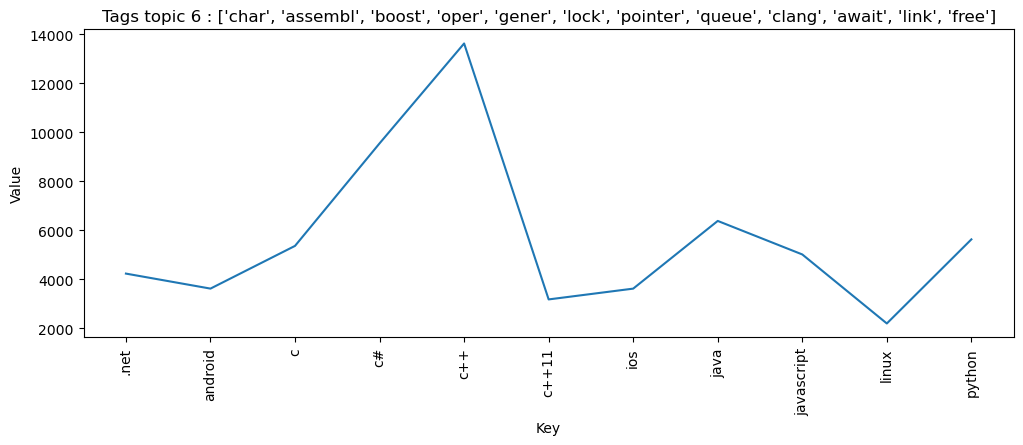



 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Topic 7 :  ['spring', 'eclips', 'jar', 'apach', 'hibern', 'boot', 'depend', 'bean', 'annot', 'mock', 'tomcat', 'sun'] 

word = spring , df_word.shape = (6634, 11)
word = spring , _Tag_1 = 4796 , _Tag_2 = 24
word = eclips , df_word.shape = (3357, 11)
word = eclips , _Tag_1 = 6775 , _Tag_2 = 309
word = jar , df_word.shape = (3631, 11)
word = jar , _Tag_1 = 1490 , _Tag_2 = 252
word = apach , df_word.shape = (4944, 11)
word = apach , _Tag_1 = 11582 , _Tag_2 = 1146
word = hibern , df_word.shape = (2580, 11)
word = hibern , _Tag_1 = 1435 , _Tag_2 = 269
word = boot , df_word.shape = (6094, 11)
word = boot , _Tag_1 = 2637 , _Tag_2 = 5575
word = depend , df_word.shape = (9300, 11)
word = depend , _Tag_1 = 331 , _Tag_2 = 112
word = bean , df_word.shape = (2467, 11)
word = bean , _Tag_1 = 19311 , _Tag_2 = 1746
word = annot , df_word.shape = (3161, 11)
word = annot , _Tag_1 = 3062 , _Tag_2 = 474

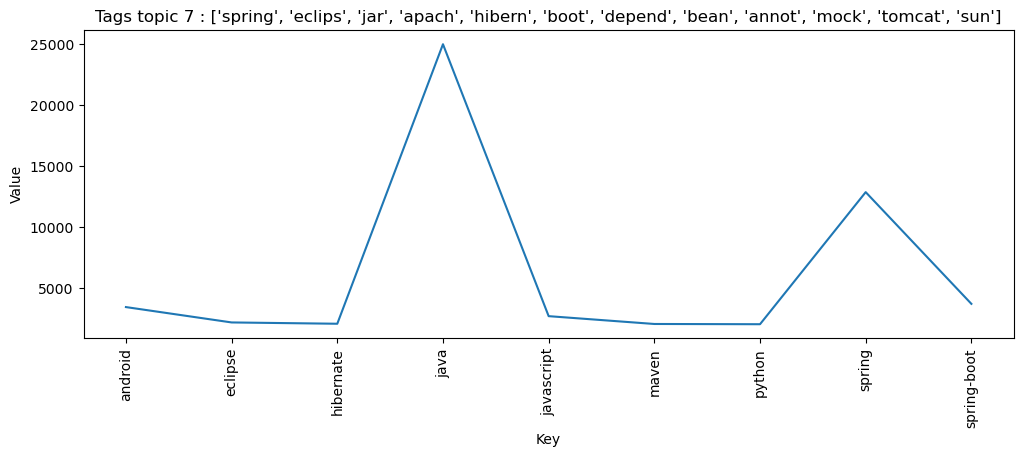

In [169]:
# graphique
graphique_topic_modeling_with_LDA(normalization_type_in = 'stemmer', 
                                  num_word_per_topic_in = 12, 
                                  lda_components_in     = lda_components_stemmer, 
                                  terms_in              = terms_stemmer)

# 2.2.2. METHODE 2

In [ ]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# Topic model : LDA
# ------------------------------------------------
# 1) Data transformation: Corpus and Dictionary
# 2) Base Model
# 3) Hyperparameter Tuning
# 4) Final Model
# 5) Visualize Results

In [13]:
#####################################################
#  1) Data Transformation : Corpus and Dictionary   #
#####################################################
# https://stackoverflow.com/questions/33229360/gensim-typeerror-doc2bow-expects-an-array-of-unicode-tokens-on-input-not-a-si
# The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.
def LDA_Data_Transformation(normalization_type_in, corpus_liste_in):
       
    # Create Dictionary
    id2word = corpora.Dictionary(corpus_liste_in)

    # Create Corpus
    texts = corpus_liste_in

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # View
    print('Term Document Frequency for', normalization_type_in, ':', corpus[:1][0][:30])
    
    return id2word, texts, corpus

In [14]:
# corpus_lemma = ' '.join(df['_Lemma_clean'])
id2word_lemma, texts_lemma, corpus_lemma = LDA_Data_Transformation(normalization_type_in = 'lemma',
                                                                   corpus_liste_in       = [corpus_liste_lemma])

Term Document Frequency for lemma : [(0, 837), (1, 15), (2, 15), (3, 73), (4, 837), (5, 36), (6, 18), (7, 3), (8, 3), (9, 126), (10, 136), (11, 9), (12, 2), (13, 22), (14, 9), (15, 2), (16, 4), (17, 2), (18, 7), (19, 62), (20, 2), (21, 14), (22, 2), (23, 9), (24, 2), (25, 3), (26, 4), (27, 2), (28, 2), (29, 19)]


In [15]:
# corpus_stemmer = ' '.join(df['_Stemmer_clean'])
id2word_stemmer, texts_stemmer, corpus_stemmer = LDA_Data_Transformation(normalization_type_in = 'stemmer',
                                                                         corpus_liste_in       = [corpus_liste_stemmer])

Term Document Frequency for stemmer : [(0, 837), (1, 15), (2, 15), (3, 73), (4, 837), (5, 36), (6, 18), (7, 3), (8, 3), (9, 262), (10, 9), (11, 2), (12, 22), (13, 11), (14, 4), (15, 2), (16, 2), (17, 69), (18, 16), (19, 9), (20, 2), (21, 7), (22, 2), (23, 2), (24, 6), (25, 25), (26, 3), (27, 1395), (28, 128), (29, 16)]


In [16]:
#####################################################
# 2) Base Model                                     #
#####################################################
def LDA_Base_Model(normalization_type_in, corpus_in, id2word_in):
    
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus          = corpus_in,
                                           id2word         = id2word_in,
                                           num_topics      = 10, 
                                           random_state    = 100,
                                           chunksize       = 100,
                                           passes          = 10,
                                           per_word_topics = True)

    # View the topics in LDA model
    # Print the Keyword in the 10 topics
    print('10 topics in LDA model for', normalization_type_in, ':')
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus_in]
    
    return lda_model

In [18]:
lda_model_lemma = LDA_Base_Model(normalization_type_in = 'lemma',
                                 corpus_in             = corpus_lemma,
                                 id2word_in            = id2word_lemma)

10 topics in LDA model for lemma :
[(0,
  '0.021*"android" + 0.007*"div" + 0.005*"spring" + 0.005*"apache" + '
  '0.004*"override" + 0.004*"jar" + 0.004*"component" + 0.004*"column" + '
  '0.004*"site" + 0.003*"security"'),
 (1,
  '0.016*"android" + 0.007*"div" + 0.005*"apache" + 0.005*"spring" + '
  '0.004*"site" + 0.004*"jar" + 0.004*"react" + 0.003*"release" + '
  '0.003*"browser" + 0.003*"label"'),
 (2,
  '0.020*"android" + 0.007*"div" + 0.006*"apache" + 0.005*"spring" + '
  '0.004*"jar" + 0.004*"title" + 0.004*"session" + 0.004*"override" + '
  '0.003*"dependency" + 0.003*"security"'),
 (3,
  '0.022*"android" + 0.008*"div" + 0.005*"apache" + 0.004*"jar" + '
  '0.004*"password" + 0.004*"action" + 0.004*"column" + 0.003*"title" + '
  '0.003*"spring" + 0.003*"final"'),
 (4,
  '0.019*"android" + 0.006*"div" + 0.005*"spring" + 0.004*"session" + '
  '0.004*"react" + 0.004*"jar" + 0.004*"apache" + 0.003*"controller" + '
  '0.003*"security" + 0.003*"title"'),
 (5,
  '0.025*"android" + 0.0

In [19]:
lda_model_stemmer = LDA_Base_Model(normalization_type_in = 'stemmer',
                                   corpus_in             = corpus_stemmer,
                                   id2word_in            = id2word_stemmer)

10 topics in LDA model for stemmer :
[(0,
  '0.021*"android" + 0.007*"div" + 0.006*"jar" + 0.005*"apach" + 0.004*"activ" '
  '+ 0.004*"password" + 0.004*"token" + 0.004*"session" + 0.004*"titl" + '
  '0.004*"secur"'),
 (1,
  '0.023*"android" + 0.008*"div" + 0.005*"jar" + 0.004*"apach" + '
  '0.004*"spring" + 0.004*"activ" + 0.004*"depend" + 0.004*"releas" + '
  '0.003*"password" + 0.003*"react"'),
 (2,
  '0.018*"android" + 0.007*"div" + 0.006*"apach" + 0.005*"spring" + '
  '0.005*"final" + 0.005*"jar" + 0.004*"activ" + 0.004*"column" + 0.003*"site" '
  '+ 0.003*"action"'),
 (3,
  '0.021*"android" + 0.009*"div" + 0.005*"apach" + 0.004*"secur" + '
  '0.004*"spring" + 0.004*"activ" + 0.004*"jar" + 0.004*"control" + '
  '0.003*"final" + 0.003*"product"'),
 (4,
  '0.021*"android" + 0.009*"div" + 0.005*"apach" + 0.005*"jar" + 0.004*"final" '
  '+ 0.004*"secur" + 0.004*"activ" + 0.004*"spring" + 0.004*"session" + '
  '0.004*"site"'),
 (5,
  '0.014*"android" + 0.006*"div" + 0.006*"spring" + 0.

In [51]:
####################################################
#   Compute Model Perplexity and Coherence Score   #
####################################################
def LDA_Coherence_Score(normalization_type_in, lda_model_in, corpus_liste_in, id2word_in):
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model      = lda_model_in, 
                                         texts      = corpus_liste_in, 
                                         dictionary = id2word_in, 
                                         coherence  = 'c_v')

    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score for', normalization_type_in, ':', coherence_lda)

In [26]:
LDA_Coherence_Score(normalization_type_in = 'lemma',
                    lda_model_in          = lda_model_lemma, 
                    corpus_liste_in       = [corpus_liste_lemma], 
                    id2word_in            = id2word_lemma)

Coherence Score for lemma : 0.3067311449555698


In [52]:
LDA_Coherence_Score(normalization_type_in = 'stemmer',
                    lda_model_in          = lda_model_stemmer, 
                    corpus_liste_in       = [corpus_liste_stemmer], 
                    id2word_in            = id2word_stemmer)

Coherence Score for stemmer : 0.29796233974032593


In [ ]:
#####################################################
# 3) Hyperparameter Tuning                          #
#####################################################
#   --> k : Number of Topics
#   --> a (Dirichlet hyperparameter alpha) : Document-Topic Density
#   --> b (Dirichlet hyperparameter beta) : Word-Topic Density

In [20]:
# supporting function
def compute_coherence_values(corpus_in, id2word_in, k_in, a_in, b_in, lda_model_in, corpus_liste_in):
    
    lda_model = gensim.models.LdaMulticore(corpus       = corpus_in,
                                           id2word      = id2word_in,
                                           num_topics   = k_in, 
                                           random_state = 100,
                                           chunksize    = 100,
                                           passes       = 10,
                                           alpha        = a_in,
                                           eta          = b_in)
    
    coherence_model_lda = CoherenceModel(model      = lda_model_in,
                                         texts      = corpus_liste_in,
                                         dictionary = id2word_in, 
                                         coherence  = 'c_v')
    
    return coherence_model_lda.get_coherence()

In [21]:
# Let’s call the function, and iterate it over the range of topics, alpha, and beta parameter values.
def LDA_hyperparameters_tuning(normalization_type_in, corpus_in, id2word_in, lda_model_in, corpus_liste_in):

    grid = {}
    grid['Validation_Set'] = {}

    # Topics range
    topics_range = [8, 10, 12]

    # Alpha parameter
    alpha = [0.01, 0.1, 1]

    # Beta parameter
    beta = [0.01, 0.1, 1]    

    # Validation sets
    num_of_docs = len(corpus_in)
    corpus_sets = [gensim.utils.ClippedCorpus(corpus_in, int(num_of_docs * 0.75)), 
                   corpus_in]

    corpus_title = ['75% Corpus', '100% Corpus']

    model_results = {'Validation_Set': [],
                     'Topics': [],
                     'Alpha': [],
                     'Beta': [],
                     'Coherence': []
                    }

    # Can take a long time to run
    if 1 == 1:
        pbar = tqdm.tqdm(total = (len(beta) * len(alpha) * len(topics_range) * len(corpus_title)))
    
        # iterate through validation corpuses
        for i in range(len(corpus_sets)):
            # iterate through number of topics
            for k in topics_range:
                # iterate through alpha values
                for a in alpha:
                    # iterare through beta values
                    for b in beta:
                        
                        print('i =', i, '/', len(corpus_sets), ', k =', k, ', a =', a, ', b =', b)
                        
                        # get the coherence score for the given parameters                     
                        cv = compute_coherence_values(corpus_in       = corpus_sets[i], 
                                                      id2word_in      = id2word_in,
                                                      k_in            = k, 
                                                      a_in            = a, 
                                                      b_in            = b,
                                                      lda_model_in    = lda_model_in,
                                                      corpus_liste_in = corpus_liste_in)
        
                        # Save the model results
                        model_results['Validation_Set'].append(corpus_title[i])
                        model_results['Topics'].append(k)
                        model_results['Alpha'].append(a)
                        model_results['Beta'].append(b)
                        model_results['Coherence'].append(cv)
                    
                        pbar.update(1)
        
        # Ecriture dans un fichier
        if (normalization_type_in == 'lemma'):
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results_lemma.csv', index = False)
        elif (normalization_type_in == 'stemmer'):
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results_stemmer.csv', index = False)
        else:
            pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index = False)            
        pbar.close()

In [22]:
LDA_hyperparameters_tuning(normalization_type_in = 'lemma',
                           corpus_in             = corpus_lemma, 
                           id2word_in            = id2word_lemma, 
                           lda_model_in          = lda_model_lemma, 
                           corpus_liste_in       = [corpus_liste_lemma]) # 1h 47min

  0%|          | 0/54 [00:00<?, ?it/s]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.01


  2%|▏         | 1/54 [01:29<1:18:40, 89.06s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.1


  4%|▎         | 2/54 [02:56<1:16:36, 88.39s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 1


  6%|▌         | 3/54 [04:29<1:16:39, 90.18s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.01


  7%|▋         | 4/54 [06:03<1:16:28, 91.77s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.1


  9%|▉         | 5/54 [07:30<1:13:29, 89.99s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 1


 11%|█         | 6/54 [09:00<1:12:03, 90.07s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.01


 13%|█▎        | 7/54 [10:18<1:07:22, 86.02s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.1


 15%|█▍        | 8/54 [11:33<1:03:21, 82.65s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 1


 17%|█▋        | 9/54 [12:48<1:00:05, 80.11s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.01


 19%|█▊        | 10/54 [14:04<57:48, 78.83s/it] 

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.1


 20%|██        | 11/54 [15:25<57:06, 79.68s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 1


 22%|██▏       | 12/54 [16:47<56:10, 80.24s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.01


 24%|██▍       | 13/54 [18:08<55:05, 80.62s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.1


 26%|██▌       | 14/54 [19:26<53:14, 79.87s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 1


 28%|██▊       | 15/54 [20:47<52:02, 80.07s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.01


 30%|██▉       | 16/54 [22:13<51:52, 81.90s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.1


 31%|███▏      | 17/54 [23:38<51:08, 82.94s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 1


 33%|███▎      | 18/54 [25:04<50:10, 83.62s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.01


 35%|███▌      | 19/54 [26:21<47:39, 81.70s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.1


 37%|███▋      | 20/54 [27:37<45:16, 79.89s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 1


 39%|███▉      | 21/54 [28:53<43:22, 78.86s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.01


 41%|████      | 22/54 [30:11<41:57, 78.67s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.1


 43%|████▎     | 23/54 [31:27<40:16, 77.94s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 1


 44%|████▍     | 24/54 [32:44<38:44, 77.48s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.01


 46%|████▋     | 25/54 [34:01<37:25, 77.42s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.1


 48%|████▊     | 26/54 [35:20<36:22, 77.95s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 1


 50%|█████     | 27/54 [36:38<35:04, 77.94s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.01


 52%|█████▏    | 28/54 [37:59<34:05, 78.69s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.1


 54%|█████▎    | 29/54 [39:21<33:10, 79.63s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 1


 56%|█████▌    | 30/54 [42:03<41:44, 104.34s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.01


 57%|█████▋    | 31/54 [44:48<47:00, 122.65s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.1


 59%|█████▉    | 32/54 [47:32<49:29, 134.98s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 1


 61%|██████    | 33/54 [50:16<50:18, 143.75s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.01


 63%|██████▎   | 34/54 [53:01<50:03, 150.17s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.1


 65%|██████▍   | 35/54 [55:46<48:56, 154.57s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 1


 67%|██████▋   | 36/54 [58:29<47:08, 157.16s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.01


 69%|██████▊   | 37/54 [1:01:14<45:11, 159.49s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.1


 70%|███████   | 38/54 [1:03:57<42:50, 160.64s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 1


 72%|███████▏  | 39/54 [1:06:43<40:33, 162.27s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.01


 74%|███████▍  | 40/54 [1:09:31<38:12, 163.78s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.1


 76%|███████▌  | 41/54 [1:12:16<35:35, 164.26s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 1


 78%|███████▊  | 42/54 [1:15:02<32:57, 164.80s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.01


 80%|███████▉  | 43/54 [1:17:46<30:11, 164.65s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.1


 81%|████████▏ | 44/54 [1:20:31<27:27, 164.72s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 1


 83%|████████▎ | 45/54 [1:23:14<24:37, 164.21s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.01


 85%|████████▌ | 46/54 [1:26:00<21:57, 164.68s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.1


 87%|████████▋ | 47/54 [1:28:44<19:10, 164.40s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 1


 89%|████████▉ | 48/54 [1:31:30<16:28, 164.79s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.01


 91%|█████████ | 49/54 [1:34:14<13:43, 164.78s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.1


 93%|█████████▎| 50/54 [1:36:59<10:59, 164.90s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 1


 94%|█████████▍| 51/54 [1:39:43<08:13, 164.56s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.01


 96%|█████████▋| 52/54 [1:42:28<05:29, 164.63s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.1


 98%|█████████▊| 53/54 [1:45:14<02:45, 165.15s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 1


100%|██████████| 54/54 [1:47:59<00:00, 119.99s/it]


In [23]:
LDA_hyperparameters_tuning(normalization_type_in = 'stemmer',
                           corpus_in             = corpus_stemmer, 
                           id2word_in            = id2word_stemmer, 
                           lda_model_in          = lda_model_stemmer, 
                           corpus_liste_in       = [corpus_liste_stemmer])  # 1h 43 min

  0%|          | 0/54 [00:00<?, ?it/s]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.01


  2%|▏         | 1/54 [01:24<1:14:39, 84.51s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 0.1


  4%|▎         | 2/54 [02:45<1:11:27, 82.44s/it]

i = 0 / 2 , k = 8 , a = 0.01 , b = 1


  6%|▌         | 3/54 [04:05<1:09:16, 81.51s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.01


  7%|▋         | 4/54 [05:24<1:07:00, 80.41s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 0.1


  9%|▉         | 5/54 [06:43<1:05:08, 79.76s/it]

i = 0 / 2 , k = 8 , a = 0.1 , b = 1


 11%|█         | 6/54 [08:01<1:03:19, 79.15s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.01


 13%|█▎        | 7/54 [09:24<1:03:02, 80.49s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 0.1


 15%|█▍        | 8/54 [10:44<1:01:42, 80.50s/it]

i = 0 / 2 , k = 8 , a = 1 , b = 1


 17%|█▋        | 9/54 [12:03<59:51, 79.82s/it]  

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.01


 19%|█▊        | 10/54 [13:21<58:11, 79.36s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 0.1


 20%|██        | 11/54 [14:37<56:10, 78.39s/it]

i = 0 / 2 , k = 10 , a = 0.01 , b = 1


 22%|██▏       | 12/54 [15:54<54:36, 78.02s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.01


 24%|██▍       | 13/54 [17:09<52:38, 77.03s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 0.1


 26%|██▌       | 14/54 [18:25<51:01, 76.54s/it]

i = 0 / 2 , k = 10 , a = 0.1 , b = 1


 28%|██▊       | 15/54 [19:41<49:40, 76.42s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.01


 30%|██▉       | 16/54 [20:59<48:44, 76.96s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 0.1


 31%|███▏      | 17/54 [22:17<47:39, 77.27s/it]

i = 0 / 2 , k = 10 , a = 1 , b = 1


 33%|███▎      | 18/54 [23:35<46:31, 77.53s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.01


 35%|███▌      | 19/54 [24:51<44:53, 76.95s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 0.1


 37%|███▋      | 20/54 [26:07<43:25, 76.64s/it]

i = 0 / 2 , k = 12 , a = 0.01 , b = 1


 39%|███▉      | 21/54 [27:23<42:11, 76.70s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.01


 41%|████      | 22/54 [28:41<41:05, 77.06s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 0.1


 43%|████▎     | 23/54 [29:59<39:51, 77.15s/it]

i = 0 / 2 , k = 12 , a = 0.1 , b = 1


 44%|████▍     | 24/54 [31:16<38:38, 77.27s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.01


 46%|████▋     | 25/54 [32:33<37:12, 77.00s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 0.1


 48%|████▊     | 26/54 [33:49<35:53, 76.92s/it]

i = 0 / 2 , k = 12 , a = 1 , b = 1


 50%|█████     | 27/54 [35:06<34:32, 76.76s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.01


 52%|█████▏    | 28/54 [36:30<34:12, 78.95s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 0.1


 54%|█████▎    | 29/54 [37:55<33:36, 80.68s/it]

i = 1 / 2 , k = 8 , a = 0.01 , b = 1


 56%|█████▌    | 30/54 [39:19<32:43, 81.81s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.01


 57%|█████▋    | 31/54 [40:45<31:48, 82.99s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 0.1


 59%|█████▉    | 32/54 [42:08<30:28, 83.10s/it]

i = 1 / 2 , k = 8 , a = 0.1 , b = 1


 61%|██████    | 33/54 [43:32<29:07, 83.22s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.01


 63%|██████▎   | 34/54 [44:55<27:45, 83.26s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 0.1


 65%|██████▍   | 35/54 [46:20<26:34, 83.91s/it]

i = 1 / 2 , k = 8 , a = 1 , b = 1


 67%|██████▋   | 36/54 [47:45<25:12, 84.02s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.01


 69%|██████▊   | 37/54 [1:18:18<2:52:28, 608.71s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 0.1


 70%|███████   | 38/54 [1:19:43<2:00:29, 451.85s/it]

i = 1 / 2 , k = 10 , a = 0.01 , b = 1


 72%|███████▏  | 39/54 [1:21:27<1:26:49, 347.32s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.01


 74%|███████▍  | 40/54 [1:22:57<1:03:04, 270.29s/it]

i = 1 / 2 , k = 10 , a = 0.1 , b = 0.1


 76%|███████▌  | 41/54 [1:24:26<46:45, 215.82s/it]  

i = 1 / 2 , k = 10 , a = 0.1 , b = 1


 78%|███████▊  | 42/54 [1:25:59<35:48, 179.01s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.01


 80%|███████▉  | 43/54 [1:27:32<28:04, 153.10s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 0.1


 81%|████████▏ | 44/54 [1:29:05<22:32, 135.21s/it]

i = 1 / 2 , k = 10 , a = 1 , b = 1


 83%|████████▎ | 45/54 [1:30:33<18:08, 120.95s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.01


 85%|████████▌ | 46/54 [1:32:02<14:50, 111.37s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 0.1


 87%|████████▋ | 47/54 [1:33:30<12:09, 104.25s/it]

i = 1 / 2 , k = 12 , a = 0.01 , b = 1


 89%|████████▉ | 48/54 [1:34:59<09:59, 99.84s/it] 

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.01


 91%|█████████ | 49/54 [1:36:27<08:00, 96.18s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 0.1


 93%|█████████▎| 50/54 [1:37:54<06:13, 93.39s/it]

i = 1 / 2 , k = 12 , a = 0.1 , b = 1


 94%|█████████▍| 51/54 [1:39:20<04:33, 91.33s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.01


 96%|█████████▋| 52/54 [1:40:48<03:00, 90.12s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 0.1


 98%|█████████▊| 53/54 [1:42:14<01:29, 89.14s/it]

i = 1 / 2 , k = 12 , a = 1 , b = 1


100%|██████████| 54/54 [1:43:43<00:00, 115.25s/it]


In [35]:
########################################
# Investigate Results                  #
########################################
def LDA_Investigate_Results(normalization_type_in):
    
    if (normalization_type_in == 'lemma'):
        df_lda = pd.read_csv('./results/lda_tuning_results_lemma.csv')
    elif (normalization_type_in == 'stemmer'):
        df_lda = pd.read_csv('./results/lda_tuning_results_stemmer.csv')
    else:
        df_lda = pd.read_csv('./results/lda_tuning_results.csv')    
     
    print('columns\t:', df_lda.columns)
    print('shape\t:', df_lda.shape, '\n')
    print('dtypes :')
    print(df_lda.dtypes)
    
    return df_lda

In [36]:
df_lda_lemma = LDA_Investigate_Results(normalization_type_in = 'lemma')

columns	: Index(['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'], dtype='object')
shape	: (54, 5) 

dtypes :
Validation_Set     object
Topics              int64
Alpha             float64
Beta              float64
Coherence         float64
dtype: object


In [37]:
df_lda_stemmer = LDA_Investigate_Results(normalization_type_in = 'stemmer')

columns	: Index(['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'], dtype='object')
shape	: (54, 5) 

dtypes :
Validation_Set     object
Topics              int64
Alpha             float64
Beta              float64
Coherence         float64
dtype: object


In [48]:
#############################################################################
# Affichage hyperparamètres LDA (topics, alpha, beta) pour stemmer et lemma #
#############################################################################
# Couleurs  : https://matplotlib.org/stable/gallery/color/named_colors.html
# Marqueurs : https://matplotlib.org/stable/api/markers_api.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

def LDA_affichage_hyperparametres():
    
    plt.figure(figsize = (15, 6))
    
    # >>>>>>> Topics % Coherence
    plt.subplot(1, 3, 1)   # lignes, colonnes
    plt.plot(df_lda_lemma['Topics'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Topics'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Topics')
    plt.ylabel('Coherence')
    plt.title('Topics % Coherence')
    plt.legend() 

    # >>>>>>> Alpha % Coherence
    plt.subplot(1, 3, 2)   # lignes, colonnes
    plt.plot(df_lda_lemma['Alpha'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Alpha'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Alpha')
    plt.ylabel('Coherence')
    plt.title('Alpha % Coherence')
    plt.legend()

    # >>>>>>> Beta % Coherence
    plt.subplot(1, 3, 3)   # lignes, colonnes
    plt.plot(df_lda_lemma['Beta'], df_lda_lemma['Coherence'], 
             color = 'blue', marker = 'o', linestyle = 'dashed', label = 'lemma')
    plt.plot(df_lda_stemmer['Beta'], df_lda_stemmer['Coherence'], 
             color = 'red', marker = 'o', linestyle = 'dashed', label = 'stemmer')
    plt.xlabel('Beta')
    plt.ylabel('Coherence')
    plt.title('Beta % Coherence')
    plt.legend()

    
    # >>>>>>> Paramètres communs
    plt.suptitle('Hyperparamètres LDA (topics, alpha, beta) pour stemmer et lemma', fontsize = 18)
    plt.tight_layout() # pour éviter chevauchement titre et ligne suivante
    plt.legend() 
    plt.show()

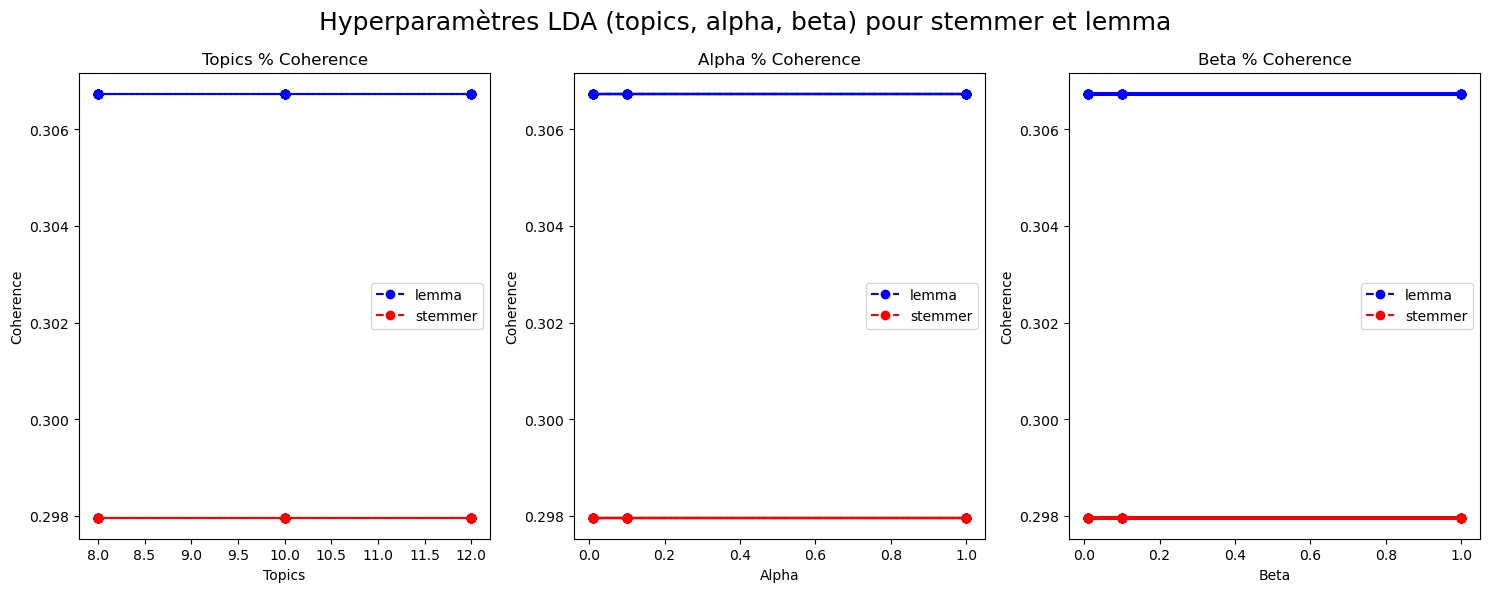

In [49]:
LDA_affichage_hyperparametres()

In [ ]:
#####################################################
# 4) Final Model                                    #
#####################################################

In [53]:
# Maj hyperparamètres : on prend la 1ère valeur de la plage car ils donnent tous le même résultat.
# Remarque : la cohérence est meilleure pour lemma que stemmer.
num_topics = 8    # Number of Topics
alpha      = 0.01 # Alpha parameter
beta       = 0.01 # Beta parameter

In [54]:
lda_model_lemma = gensim.models.LdaMulticore(corpus       = corpus_lemma,
                                             id2word      = id2word_lemma,
                                             num_topics   = num_topics, # hyperparamètre
                                             random_state = 100,
                                             chunksize    = 100,
                                             passes       = 10,
                                             alpha        = alpha,      # hyperparamètre
                                             eta          = beta)       # hyperparamètre

In [55]:
lda_model_stemmer = gensim.models.LdaMulticore(corpus       = corpus_stemmer,
                                               id2word      = id2word_stemmer,
                                               num_topics   = num_topics, # hyperparamètre
                                               random_state = 100,
                                               chunksize    = 100,
                                               passes       = 10,
                                               alpha        = alpha,      # hyperparamètre
                                               eta          = beta)       # hyperparamètre

In [66]:
#####################################################
# 5) Visualize Results                              #
#####################################################
def LDA_Visualize_Results(normalization_type_in, corpus_in, id2word_in, lda_model_in):

    # Visualize the topics
    pyLDAvis.enable_notebook()

    LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+ str(num_topics))

    # this is a bit time consuming - make the if statement True
    # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = gensimvis.prepare(lda_model_in, corpus_in, id2word_in)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    
    if (normalization_type_in == 'lemma'):
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_lemma_'+ str(num_topics) +'.html')
    elif (normalization_type_in == 'stemmer'):
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_stemmer_'+ str(num_topics) +'.html')
    else:
        pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

    LDAvis_prepared

In [67]:
LDA_Visualize_Results(normalization_type_in = 'lemma', 
                      corpus_in             = corpus_lemma, 
                      id2word_in            = id2word_lemma, 
                      lda_model_in          = lda_model_lemma)

In [68]:
LDA_Visualize_Results(normalization_type_in = 'stemmer', 
                      corpus_in             = corpus_stemmer, 
                      id2word_in            = id2word_stemmer, 
                      lda_model_in          = lda_model_stemmer)

In [ ]:
# transformation manuelle du fichier html --> jpg

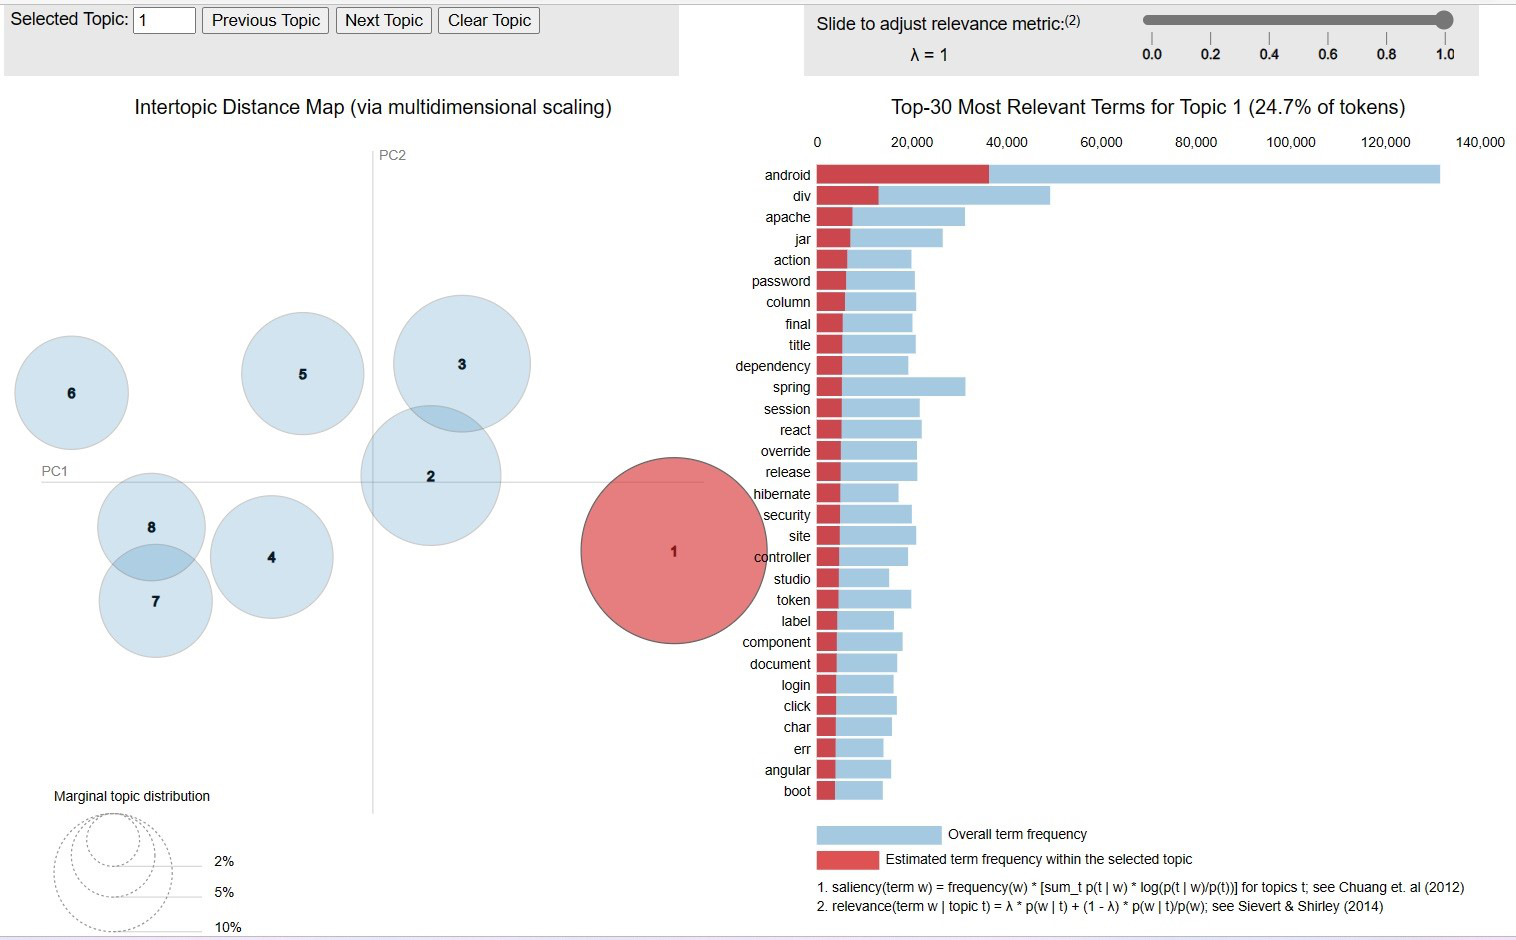

In [57]:
Image.open('./results/ldavis_tuned_lemma_8.jpg')

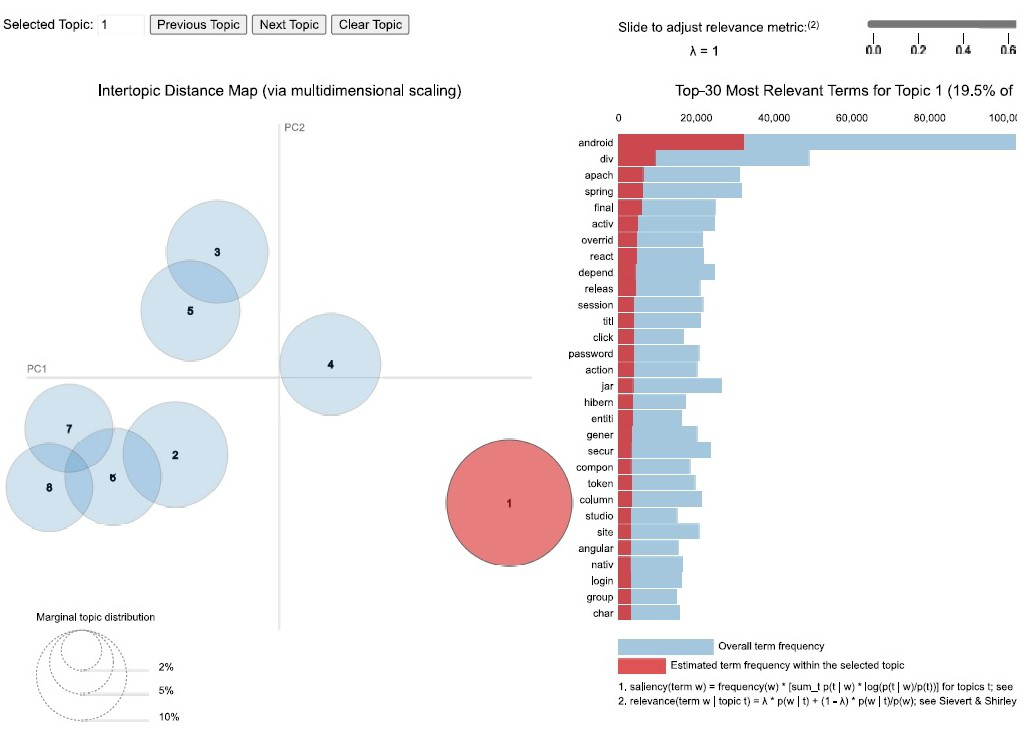

In [56]:
Image.open('./results/ldavis_tuned_stemmer_8.jpg')

# 3. MACHINE LEARNING SUPERVISE

In [ ]:


https://stacklima.com/analyse-des-composants-principaux-avec-python/
    
    

# 3.1. DECOUPAGE DONNEES

# 3.1.1. DECOUPAGE DONNEES EN X ET Y

In [17]:
df.columns

Index(['CreationDate', 'Id', 'Score', 'AnswerCount', '_Tag_1', '_Tag_2',
       '_Text_clean', '_Stemmer_clean', '_Lemma_clean'],
      dtype='object')

In [ ]:
###############################################
# X : données d'entrée                        #
###############################################

In [18]:
X = df.drop(['_Tag_1', '_Tag_2'], axis = 1)

# Affichage pour vérifier
print(X.columns, '\n')
print(X.head())

Index(['CreationDate', 'Id', 'Score', 'AnswerCount', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean'],
      dtype='object') 

          CreationDate    Id  Score  AnswerCount  \
0  2008-08-09 04:13:02  6607     55           13   
1  2008-08-06 19:26:30  3881    570           26   
2  2008-08-07 02:29:58  4306     62           11   
3  2008-08-09 21:16:29  6915     38            9   
4  2008-08-09 06:50:22  6666     34            7   

                                         _Text_clean  \
0              registry programmer friendly registry   
1  setter appropriate torn situation throw approp...   
2  sparse manipulation enormous matrices specific...   
3  safe lazy construction singleton singleton laz...   
4              benefit regular fashion visual studio   

                                      _Stemmer_clean  \
0                registri programm friendli registri   
1  setter appropri torn situat throw appropri und...   
2  spars manipul enorm matric specif pyramid sum

In [ ]:
###############################################
# y : données de sortie (résultat)            #
###############################################

In [19]:
# Copie des 2 sorties y (_Tag_1 et _Tag_2) dans un dataframe.
df_y = df[['_Tag_1', '_Tag_2']].copy()
df_y.shape

(207636, 2)

In [22]:
# Vérification n°1
for index, row in df.iterrows():
    if (row['_Tag_1'] != df_y.loc[index, '_Tag_1']):
        print('index =', index, ': _Tag_1 différent : df =', row['_Tag_1'], ', df_y =', df_y.loc[index, '_Tag_1'])
    if (row['_Tag_2'] != df_y.loc[index, '_Tag_2']):
        print('index =', index, ': _Tag_2 différent : df =', row['_Tag_2'], ', df_y =', df_y.loc[index, '_Tag_2'])

In [21]:
# Vérification n°2
print('@' * 16, 'df - head :', '@' * 16, '\n', df[['_Tag_1', '_Tag_2']].head(), '\n\n')
print('@' * 15, 'df_y - head :', '@' * 15, '\n', df_y.head(), '\n\n')

print('@' * 16, 'df - tail :', '@' * 16, '\n', df[['_Tag_1', '_Tag_2']].tail(), '\n\n')
print('@' * 15, 'df_y - tail :', '@' * 15, '\n', df_y.tail())

@@@@@@@@@@@@@@@@ df - head : @@@@@@@@@@@@@@@@ 
     _Tag_1          _Tag_2
0  windows               /
1     java       exception
2      c++               /
3      c++  multithreading
4     .net   visual-studio 


@@@@@@@@@@@@@@@ df_y - head : @@@@@@@@@@@@@@@ 
     _Tag_1          _Tag_2
0  windows               /
1     java       exception
2      c++               /
3      c++  multithreading
4     .net   visual-studio 


@@@@@@@@@@@@@@@@ df - tail : @@@@@@@@@@@@@@@@ 
             _Tag_1    _Tag_2
207631  javascript         /
207632      python  selenium
207633         c++         /
207634         c++         /
207635  javascript   reactjs 


@@@@@@@@@@@@@@@ df_y - tail : @@@@@@@@@@@@@@@ 
             _Tag_1    _Tag_2
207631  javascript         /
207632      python  selenium
207633         c++         /
207634         c++         /
207635  javascript   reactjs


In [36]:
# Conversion dataframe --> liste
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ Y : df_y --> list_y                                    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# https://stacklima.com/comment-convertir-pandas-dataframe-en-une-liste/
list_y = df_y.values.tolist()

# Vérification
print('list_y :')
print('\t- nb éléments\t\t=', len(list_y))
print('\t- 5 premiers éléments\t=', list_y[0:5])

list_y :
	- nb éléments		= 207636
	- 5 premiers éléments	= [['windows', '/'], ['java', 'exception'], ['c++', '/'], ['c++', 'multithreading'], ['.net', 'visual-studio']]


In [37]:
########################################################################################################
# Nous sommes dans un cas de Multi-label text classification, car la sortie est sur _Tag_1 et _Tag_2.  #
# => Transform between iterable of iterables and a multilabel format.                                  #
########################################################################################################


# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
# https://scikit-learn.org/stable/modules/preprocessing_targets.html
# https://medium.com/analytics-vidhya/multi-label-text-classification-for-beginners-in-less-than-five-5-minutes-19502a96cf39

mlb = MultiLabelBinarizer()

#----------------------------------------------------------------------------------------------
# fit_transform(y) : Fit the label sets binarizer and transform the given label sets.
# Parameters:
#   - y : iterable of iterables.
#     A set of labels (any orderable and hashable object) for each sample. If the classes parameter is set, 
#     y will not be iterated.

# Returns:
#    - y_indicator{ndarray, sparse matrix} of shape (n_samples, n_classes).
#      A matrix such that y_indicator[i, j] = 1 iff classes_[j] is in y[i], and 0 otherwise. 
#      Sparse matrix will be of CSR format.
#----------------------------------------------------------------------------------------------
mlb_indicator = mlb.fit_transform(list_y)

print(type(mlb_indicator))
mlb_indicator

<class 'numpy.ndarray'>


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
print('classes_ :')
print('\t- nb éléments\t=', len(mlb.classes_))
print('\t- liste\t\t=\n', mlb.classes_)

classes_ :
	- nb éléments	= 100
	- liste		=
 ['.net' '/' 'ajax' 'algorithm' 'amazon-web-services' 'android'
 'android-studio' 'angular' 'angularjs' 'api' 'arrays' 'asp.net'
 'asp.net-core' 'asp.net-mvc' 'assembly' 'asynchronous' 'authentication'
 'bash' 'c' 'c#' 'c++' 'c++11' 'cocoa' 'cocoa-touch' 'css' 'database'
 'dataframe' 'debugging' 'django' 'docker' 'eclipse' 'entity-framework'
 'exception' 'firebase' 'gcc' 'git' 'google-chrome' 'gradle' 'hibernate'
 'html' 'http' 'image' 'ios' 'iphone' 'java' 'javascript' 'jpa' 'jquery'
 'json' 'laravel' 'linux' 'list' 'machine-learning' 'macos' 'maven'
 'mongodb' 'multithreading' 'mysql' 'node.js' 'numpy' 'objective-c'
 'optimization' 'pandas' 'performance' 'php' 'postgresql' 'python'
 'python-2.7' 'python-3.x' 'qt' 'r' 'reactjs' 'regex' 'rest' 'ruby'
 'ruby-on-rails' 'scala' 'security' 'selenium' 'shell' 'spring'
 'spring-boot' 'spring-mvc' 'sql' 'sql-server' 'ssl' 'string' 'swift'
 'templates' 'testing' 'twitter-bootstrap' 'typescript' 'ubun

In [39]:
#y = np.array(mlb)
y = mlb_indicator

In [42]:
y.shape

(207636, 100)

In [43]:
print(y)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# 3.1.2. DECOUPAGE DONNEES EN TRAIN ET TEST

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) # test_size = 0.25, train_size = 0.75
#X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), random_state = 42) 

#https://stackoverflow.com/questions/65030825/multi-label-imbalanced-train-test-split

In [45]:
# Vérification
print('X_train\t=', X_train.shape)
print('X_test\t=',  X_test.shape)
print('y_train\t=', y_train.shape)
print('y_test\t=',  y_test.shape)

X_train	= (155727, 7)
X_test	= (51909, 7)
y_train	= (155727, 100)
y_test	= (51909, 100)


In [ ]:
%%%%%%%%%%%%%%%%%%%%%%%%% 
LDA : faire topic + y origine. Analyser performance % tags.

In [ ]:
%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# 3.1. EXTRACTION DE FEATURE "BOW (BAG OF WORDS)"

In [ ]:
# https://andhint.github.io/machine-learning/nlp/Feature-Extraction-From-Text/


In [ ]:
+ Réduction dim : ACP

In [ ]:


https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-manipuler-les-tableaux-en-python
créer un tableau    
    
https://medium.com/analytics-vidhya/multi-label-text-classification-for-beginners-in-less-than-five-5-minutes-19502a96cf39
    
    multi-label text classification
    
    

In [ ]:
###############################################
#           Découpage train / test            #
###############################################

In [ ]:
https://datascience.stackexchange.com/questions/118450/how-to-do-train-test-split-for-multi-class-classification
https://datascience.stackexchange.com/questions/78194/is-it-possible-to-have-stratified-train-test-split-of-a-set-based-on-two-columns 
https://stackoverflow.com/questions/45516424/sklearn-train-test-split-on-pandas-stratify-by-multiple-columns 

            
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
###############################################
#     CountVectorizer est une approche BOW    #
###############################################

In [ ]:
messages = ["Hey hey hey lets go get lunch today :)",
           "Did you go home?",
           "Hey!!! I need a favor"]

In [ ]:
$$$$$$$$$$$$$$$$$$$$$$
dtm = vect.fit_transform(messages)
pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

In [ ]:
!!!!!!!!!!!!!!!!!!!!!!!!!
# creating DTMs
vect = CountVectorizer()
# Document term matrix
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# creating and training logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_dtm, y_train)
y_predicted = logreg.predict(X_test_dtm)  # predicting

In [ ]:
@@@@@@@@@@@@@@@@@@@ ALGO (3) => MAJ numéro §

In [ ]:
https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
https://www.kaggle.com/code/kkhandekar/1-vs-1-1-vs-rest-classification-sklearn
https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

In [ ]:
One-Vs-Rest for Multi-Class Classification
One-vs-rest (OvR for short, also referred to as One-vs-All or OvA) is a heuristic method for using binary classification algorithms for multi-class classification.

It involves splitting the multi-class dataset into multiple binary classification problems. A binary classifier is then trained on each binary classification problem and predictions are made using the model that is the most confident.

For example, given a multi-class classification problem with examples for each class ‘red,’ ‘blue,’ and ‘green‘. This could be divided into three binary classification datasets as follows:

Binary Classification Problem 1: red vs [blue, green]
Binary Classification Problem 2: blue vs [red, green]
Binary Classification Problem 3: green vs [red, blue]

In [ ]:

# logistic regression for multi-class classification using built-in one-vs-rest
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define model
model = LogisticRegression(multi_class = 'ovr')
# fit model
model.fit(X, y)
# make predictions
yhat = model.predict(X)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define model
model = LogisticRegression()
# define the ovr strategy
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X, y)
# make predictions
yhat = ovr.predict(X)

# 3.2. EXTRACTION DE FEATURE "WORD / SENTENCE EMBEDDING"

In [ ]:
Word2Vec (ou Doc2Vec, Glove…), BERT et USE. 

NB Exemple_Tweets_Feature-extraction_Sentence+Embedding_V1.1 :
voici un notebook avec un exemple de mise en œuvre des approches Word2Vec (ou Doc2Vec, Glove…), BERT et USE sur 
un autre dataset. Vous pouvez l’étudier et l’utiliser comme point de départ. Cela vous fera gagner beaucoup de temps !

In [ ]:
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ STOP LECTURE

# 5.4. FREQUENCE DISTRIBUTION N-GRAM

In [ ]:


#############################################
#              CountVectorizer              #
#############################################
# N-grams (sets of consecutive words)
def count_vectorizer(corpus_in, ngram_min_in, ngram_max_in):
    vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (ngram_min_in, ngram_max_in))

    # Learn the vocabulary dictionary and return document-term matrix.
    DTM = vectorizer.fit_transform(corpus_in)
#   print("\nStemmer / Feature names : ", vectorizer.get_feature_names())
#   print("Stemmer / Array : ", X_stemmer.toarray())
    
    # Transforms the data into a bag of words
    count_train = vectorizer.fit(corpus_in)
    bag_of_word = vectorizer.transform(corpus_in)
    
    # Vocabulary and vocabulary ID
    print("Vocabulary size: {}".format(len(count_train.vocabulary_)))
    #print("Vocabulary content:\n {}".format(X_stemmer.vocabulary_))
        
    return DTM, count_train, bag_of_word

In [ ]:
# >>>> Stemming : 1-gram
DTM_stemmer, count_train_stemmer, BOW_stemmer = count_vectorizer(corpus_in    = corpus_liste_stemmer, 
                                                                 ngram_min_in = 1, 
                                                                 ngram_max_in = 1)

In [ ]:
# >>>> Lemmatization : 1-gram
DTM_lemma, count_train_lemma, BOW_lemma = count_vectorizer(corpus_in    = corpus_liste_lemma, 
                                                           ngram_min_in = 1, 
                                                           ngram_max_in = 1)

In [ ]:
# >>>> Stemming : 2-grams
DTM_stemmer2, count_train_stemmer2, BOW_stemmer2 = count_vectorizer(corpus_in    = corpus_liste_stemmer, 
                                                                    ngram_min_in = 2,
                                                                    ngram_max_in = 2) 

In [ ]:
# >>>> Lemmatization : 2-grams
DTM_lemma2, count_train_lemma2, BOW_lemma2 = count_vectorizer(corpus_in    = corpus_liste_lemma, 
                                                              ngram_min_in = 2, 
                                                              ngram_max_in = 2)

In [ ]:
# >>>> Stemming : 3-grams
DTM_stemmer3, count_train_stemmer3, BOW_stemmer3 = count_vectorizer(corpus_in    = corpus_liste_stemmer, 
                                                                    ngram_min_in = 3,
                                                                    ngram_max_in = 3)

In [ ]:
# >>>> Lemmatization : 3-grams
DTM_lemma3, count_train_lemma3, BOW_lemma3 = count_vectorizer(corpus_in    = corpus_liste_lemma, 
                                                              ngram_min_in = 3, 
                                                              ngram_max_in = 3)

In [ ]:
#############################################
#          Frequence distribution           #
#############################################
def frequence_distribution(operation_in, colonne_in, most_common_in):
   
    for index, row in df.iterrows():
        token = word_tokenize(row[colonne_in])
        
        # Frequence distribution
        if (index == 0):
            fdist = FreqDist(token)
        elif (operation_in == '+'):
            fdist = fdist + FreqDist(token)
        elif (operation_in == '&'):
            fdist = fdist & FreqDist(token)

    # most_common_p most common words
    most_common = fdist.most_common(most_common_in)
    print(most_common_in, 'most_common :', most_common)

    # Frequency Distribution Plot
    fig = plt.figure(figsize = (10, 5))  # Width, height
    fdist.plot(most_common_in, cumulative = False)
    plt.show()
#    fig.savefig('freqDist_' + file_name_p + '.png', bbox_inches = "tight")
    
    return most_common

In [ ]:
def frequence_distribution_ngram(vocabulary_in, most_common_in): ### OLD
    
#    for word in vocabulary_in : 
#        print(word, vocabulary_in[word]) 

    # >>>>>>> most_common_in mots en partant du début
    sortedDict_debut = sorted(vocabulary_in.items(), key = lambda x: x[1], reverse = False)

    # most_common_in most common words
    most_common_debut = sortedDict_debut[0:most_common_in]
    print(most_common_in, 'most_common_debut :', most_common_debut, '\n')
    
    
    # >>>>>>> most_common_in mots en parant de la fin
    sortedDict_fin = sorted(vocabulary_in.items(), key = lambda x: x[1], reverse = True)

    # most_common_in most common words
    most_common_fin = sortedDict_fin[0:most_common_in]
    print(most_common_in, 'most_common_fin :', most_common_fin)
    
#    return most_common_debut, most_common_fin

In [ ]:
# Frequence distribution / lemmatization : 'or' mathematical operation on the 40 most common 1-gram.
most_common_lemma_or = frequence_distribution(operation_in   = '+', 
                                              colonne_in     = '_Lemma_clean',
                                              most_common_in = 40)

In [ ]:
# Frequence distribution / stemming : 'or' mathematical operation on the 40 most common 1-gram.
most_common_stemmer_or = frequence_distribution(operation_in   = '+', 
                                                colonne_in     = '_Stemmer_clean',
                                                most_common_in = 40)

In [ ]:
# Frequence distribution / lemmatization : on the 40 most common 2-grams.
frequence_distribution_ngram(vocabulary_in  = count_train_lemma2.vocabulary_, 
                             most_common_in = 40)

In [ ]:
# Frequence distribution / stemming : on the 40 most common 2-grams.
frequence_distribution_ngram(vocabulary_in  = count_train_stemmer2.vocabulary_, 
                             most_common_in = 40)

In [ ]:
# Frequence distribution / lemmatization : on the 40 most common 3-grams.
frequence_distribution_ngram(vocabulary_in  = count_train_lemma3.vocabulary_, 
                             most_common_in = 40)

In [ ]:
# Frequence distribution / stemming : on the 40 most common 3-grams.
frequence_distribution_ngram(vocabulary_in  = count_train_stemmer3.vocabulary_, 
                             most_common_in = 40)